In [1]:
import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt
import networkx as nx

import warnings
warnings.filterwarnings("ignore")

from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
import pprint
import nltk
from nrclex import NRCLex
import re

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from collections import OrderedDict
from operator import itemgetter

%matplotlib inline
from matplotlib import pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from nltk.sentiment import SentimentIntensityAnalyzer
import yfinance as yf

# model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import math
from scipy import stats
from scipy.stats import randint
import shap

import sys
import warnings
if not sys.warnoptions: warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# tickers_list = ['DIS']
# data = yf.download(tickers_list,'2010-1-1')
# data.to_csv('dis_return.csv')

In [3]:
def add_market_open_date(df, date_name='date'):
    assign_date = []

    for date in df['date']:
        if date not in stock_date_open:
            for open_date in stock_date_open:
                if open_date > date:
                    assign_date.append(open_date)
                    break
        else: assign_date.append(date)
    
    df['closest_market_date'] = assign_date
    return df

In [4]:
def train_test_data(data):
    Y = data["return"]
    X = data.drop(["return","Date"],axis = 1)
    #X = data.iloc[:,:-2]
    X_train, X_test, Y_train,Y_test = train_test_split(X,Y,test_size = 0.3, random_state=42)
    return X_train, X_test, Y_train, Y_test, X, Y

def sub_feature_importance(model):
    model.fit(X_train, Y_train)
    importances = model.feature_importances_
    indices = np.argsort(importances)
    imp = pd.DataFrame()
    imp['features'] = X_train.columns
    imp['imp'] = importances
    print(imp.sort_values(by='imp',ascending=False))
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,8))
    ax1.set_title('Topic Importances')
    topic_importance = imp[imp.features.isin(topic)].sort_values(by='imp',ascending=True)
    
    ax1.barh(range(topic_importance.shape[0]),topic_importance['imp'],color='b', align='center')
    ax1.set_yticks(range(topic_importance.shape[0]))
    ax1.set_yticklabels(topic_importance.features)
    ax2.set_title('Sentiment Importance')
    
    sent_importance=imp[imp.features.isin(sent)].sort_values(by='imp',ascending=True)
    ax2.barh(range(sent_importance.shape[0]),sent_importance['imp'],color='b', align='center')
    ax2.set_yticks(range(sent_importance.shape[0]))
    ax2.set_yticklabels(sent_importance.features)
    ax3.set_title('Macro Importance')
    macro_importance=imp[imp.features.isin(ecnm)].sort_values(by='imp',ascending=True)
   
    ax3.barh(range(macro_importance.shape[0]),macro_importance['imp'],color='b', align='center')
    ax3.set_yticklabels(macro_importance.features)
    ax3.set_yticks(range(macro_importance.shape[0]))
    
    return model

def get_features(grid_pipe):
    importances = grid_pipe.best_estimator_.named_steps["reg"].feature_importances_
    indices = np.argsort(importances)
    imp = pd.DataFrame()
    imp['features'] = X_train.columns
    imp['imp'] = importances
    
    topic_importance = imp[imp.features.isin(topic)].sort_values(by='imp',ascending=False)[:5]
    sent_importance = imp[imp.features.isin(sent)].sort_values(by='imp',ascending=False)[:5]
    macro_importance = imp[imp.features.isin(ecnm)].sort_values(by='imp',ascending=False)[:5]
    
    period_feature = topic_importance.append(sent_importance).append(macro_importance)
    return period_feature

# 2010/01 - 2015/06

## Data Preprocess

In [5]:
START_PERIOD = '2010/01/01'
END_PERIOD = '2015/06/01'

# 8 files
dis_twitter = pd.read_csv("DIS_2010-12-31_2021-06-30_twitter_Sentimental_NoDuplicates.csv")
dis_cnbc = pd.read_csv("/Users/emma/Desktop/MS Data Challenge/Model/dis_news.csv")
dis_return_data = pd.read_csv("/Users/emma/Desktop/MS Data Challenge/Model/dis_return.csv")
eco = pd.read_csv("/Users/emma/Desktop/MS Data Challenge/WRDS/CRSP_Stock_Market_Indexes.csv")
treasury = pd.read_csv("/Users/emma/Desktop/MS Data Challenge/WRDS/US_Treasury&Inflation_(monthly).csv")
macro = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/WRDS/US_Macro.csv')
ex_rate = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/WRDS/Exchange Rates.csv')
company = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/WRDS/dis_updated.csv')

dis_return_data['return'] = (dis_return_data['Close'] - dis_return_data['Open'])/dis_return_data['Open']
stock_date_open = dis_return_data['Date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date()).tolist()
dis_return_data = dis_return_data[['Date', 'return']]
dis_return_data['Date'] = pd.to_datetime(dis_return_data['Date'])

### Twitter

In [6]:
dis_twitter['date'] = pd.to_datetime(dis_twitter['date'], errors='coerce')
dis_twitter = dis_twitter[(dis_twitter['date'] >= datetime.strptime(START_PERIOD, '%Y/%m/%d'))
                        & (dis_twitter['date'] <= datetime.strptime(END_PERIOD, '%Y/%m/%d'))]
dis_twitter = add_market_open_date(dis_twitter, 'date')
dis_twitter['closest_market_date'] = dis_twitter['closest_market_date'].apply(lambda x: x.date())
dis_df = dis_twitter.groupby("closest_market_date")['fear', 'anger', 'anticip', 'trust', 'surprise',
       'positive', 'negative', 'sadness', 'disgust', 'joy'].mean().reset_index()

dis_df_shift_lag_1 = dis_df.drop('closest_market_date', axis=1).shift(periods=1, axis=0)
dis_df_shift_lag_1.columns = [col+'_lag_1' for col in dis_df_shift_lag_1.columns]
dis_df_shift_lag_2 = dis_df.drop('closest_market_date', axis=1).shift(periods=2, axis=0)
dis_df_shift_lag_2.columns = [col+'_lag_2' for col in dis_df_shift_lag_2.columns]
temp = dis_df.rolling(window=3, min_periods=1).agg(['mean', 'std'])
temp.columns = list(map('_'.join, temp.columns.values))
dis_df = pd.concat([dis_df[['closest_market_date']], 
                    temp,
                    dis_df.drop('closest_market_date', axis=1), 
                    dis_df_shift_lag_1, 
                    dis_df_shift_lag_2], axis=1)
dis_df

,closest_market_date,fear_mean,fear_std,anger_mean,anger_std,anticip_mean,anticip_std,trust_mean,trust_std,surprise_mean,...,fear_lag_2,anger_lag_2,anticip_lag_2,trust_lag_2,surprise_lag_2,positive_lag_2,negative_lag_2,sadness_lag_2,disgust_lag_2,joy_lag_2
0,2010-12-31,0.003876,NaN,0.003876,NaN,0.0,NaN,0.054953,NaN,0.021564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-03,0.011858,0.011289,0.006673,0.003956,0.0,0.0,0.068139,0.018649,0.021226,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-01-04,0.013291,0.008359,0.007625,0.003247,0.0,0.0,0.063503,0.015439,0.022900,...,0.003876,0.003876,0.0,0.054953,0.021564,0.184761,0.043005,0.010982,0.007106,0.053273
3,2011-01-05,0.016568,0.003087,0.009216,0.000494,0.0,0.0,0.062457,0.016386,0.024789,...,0.019840,0.009470,0.0,0.081326,0.020887,0.240168,0.049151,0.011704,0.009530,0.046656
4,2011-01-06,0.016893,0.003610,0.012635,0.006160,0.0,0.0,0.051104,0.003537,0.023878,...,0.016156,0.009530,0.0,0.054231,0.026248,0.235428,0.034932,0.011892,0.008109,0.042460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,2015-05-26,0.019062,0.003150,0.010344,0.003110,0.0,0.0,0.062653,0.008564,0.034127,...,0.015750,0.007748,0.0,0.072457,0.022352,0.201704,0.050867,0.013023,0.007041,0.043817
1104,2015-05-27,0.022701,0.003672,0.013632,0.004060,0.0,0.0,0.048705,0.015707,0.083801,...,0.019417,0.009495,0.0,0.058865,0.023404,0.190837,0.043913,0.013140,0.007438,0.040586
1105,2015-05-28,0.021501,0.005443,0.015217,0.002085,0.0,0.0,0.047898,0.014970,0.103764,...,0.022020,0.013791,0.0,0.056636,0.056624,0.187124,0.051039,0.015749,0.005715,0.044889
1106,2015-05-29,0.021920,0.005550,0.014431,0.003093,0.0,0.0,0.052957,0.020819,0.106555,...,0.026666,0.017611,0.0,0.030613,0.171377,0.130726,0.099118,0.014143,0.006432,0.040707


### News

In [7]:
dis_cnbc['date'] = pd.to_datetime(dis_cnbc['date']).apply(lambda x: x.date())
dis_cnbc = add_market_open_date(dis_cnbc, 'date')
dis_cnbc_agg = dis_cnbc.groupby(['closest_market_date', 'topic'])['compound_sent'].sum().reset_index()
dis_cnbc_agg.columns = ['Date', 'topic', 'compound_sent_cnbc']

temp_df = dis_cnbc_agg.pivot(index='Date', 
                             columns='topic', 
                             values='compound_sent_cnbc').reset_index().rename_axis(None, axis=1)
temp_df['Date'] = pd.to_datetime(temp_df['Date'])
dis_return_data['Date'] = pd.to_datetime(dis_return_data['Date'])
dis_return_data = dis_return_data.merge(temp_df, how='left', on='Date')
dis_return_data = dis_return_data.fillna(0)
dis_df['closest_market_date'] = pd.to_datetime(dis_df['closest_market_date'])
dis_return_data['Date'] = pd.to_datetime(dis_return_data['Date'])
ret_df = dis_return_data.merge(dis_df, how='left', left_on='Date', right_on='closest_market_date')
# ret_df = ret_df.dropna()
ret_df = ret_df.drop("closest_market_date", axis=1)

ret_df

,Date,return,0,1,2,3,4,5,6,7,...,fear_lag_2,anger_lag_2,anticip_lag_2,trust_lag_2,surprise_lag_2,positive_lag_2,negative_lag_2,sadness_lag_2,disgust_lag_2,joy_lag_2
0,2010-01-04,-0.013231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,-0.002495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-06,-0.002508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-07,0.001889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-08,0.006949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2910,2021-07-27,0.007013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2911,2021-07-28,-0.003283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2912,2021-07-29,-0.008120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2913,2021-07-30,-0.008506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Macro

In [9]:
eco = pd.read_csv("/Users/emma/Desktop/MS Data Challenge/WRDS/CRSP_Stock_Market_Indexes.csv")
treasury = pd.read_csv("/Users/emma/Desktop/MS Data Challenge/WRDS/US_Treasury&Inflation_(monthly).csv")
macro = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/WRDS/US_Macro.csv')
ex_rate = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/WRDS/Exchange Rates.csv')
company = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/WRDS/dis_updated.csv')

eco.DATE = eco.DATE.astype(str)
eco.DATE = eco.DATE.apply(lambda x: datetime.strptime(x, '%Y%m%d'))
eco_shift = eco.drop('DATE', axis=1).shift(periods=-1, axis=0)
eco = pd.concat([eco['DATE'], eco_shift], axis=1)

df = ret_df.merge(eco, how='left', left_on='Date',right_on='DATE')
df.Date.nunique()

,DATE,vwretd,vwretx,ewretd,ewretx,sprtrn,spindx,totval,totcnt,usdval,usdcnt
0,2010-01-04,0.003374,0.003369,0.002475,0.002451,0.003116,1136.52,1.614331e+10,6556.0,1.608922e+10,6555.0
1,2010-01-05,0.002046,0.001763,0.003210,0.003180,0.000546,1137.14,1.617134e+10,6553.0,1.614323e+10,6553.0
2,2010-01-06,0.002861,0.002823,0.006887,0.006834,0.004001,1141.69,1.621673e+10,6551.0,1.617109e+10,6550.0
3,2010-01-07,0.004174,0.004174,0.007230,0.007224,0.002882,1144.98,1.628596e+10,6559.0,1.621672e+10,6550.0
4,2010-01-08,0.001141,0.001140,0.003568,0.003547,0.001747,1146.98,1.630845e+10,6559.0,1.628596e+10,6558.0
...,...,...,...,...,...,...,...,...,...,...,...
2764,2020-12-24,0.003870,0.003859,0.001350,0.001304,0.008723,3735.36,4.957939e+10,7516.0,4.938770e+10,7514.0
2765,2020-12-28,-0.003649,-0.003657,-0.008483,-0.008656,-0.002227,3727.04,4.939700e+10,7522.0,4.957673e+10,7514.0
2766,2020-12-29,0.003281,0.003114,0.010155,0.009754,0.001342,3732.04,4.955132e+10,7521.0,4.939670e+10,7519.0
2767,2020-12-30,0.003556,0.003497,-0.001058,-0.001129,0.006439,3756.07,4.981353e+10,7525.0,4.955100e+10,7519.0


In [11]:
treasury.caldt = treasury.caldt.astype(str)
treasury.caldt = treasury.caldt.apply(lambda x: datetime.strptime(x, '%Y%m%d'))
treasury['month_year'] = pd.to_datetime(treasury['caldt']).dt.to_period('M')

df['Year'] = df['Date'].dt.to_period('Y')
df['Year'] = df['Year'].apply(lambda x: float(str(x)))
df = df.merge(macro, how='left', on='Year')

df['month_year'] = pd.to_datetime(df['Date']).dt.to_period('M')
df = df.merge(treasury, how='left', on='month_year')

df.drop(columns=['DATE','month_year','caldt','Year'],inplace=True)
df.dropna(inplace=True)

df['GDP'] = df['GDP'].apply(lambda x: float(x[1:-1].replace(',',''))*1000000000)

df['GDP Growth (%)'] = df['GDP Growth (%)'].apply(lambda x: float(x[:-1].replace('%',''))/100)

df['US Federal Corporate Tax Rate'] = df['US Federal Corporate Tax Rate'].apply(lambda x: float(x[:-1].replace('%',''))/100)
#df=df.fillna(0)

ex_rate['Date'] = ex_rate.DATE.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

df = df.merge(ex_rate, how='left', on='Date')

def ex_rate(x):
    try: return float(x)
    except: return np.nan
df['DTWEXAFEGS'] = df['DTWEXAFEGS'].apply(lambda x: ex_rate(x))
df['DTWEXAFEGS'] = df['DTWEXAFEGS'].fillna(method='ffill')
df

,Date,return,0,1,2,3,4,5,6,7,...,b10ret,b7ret,b5ret,b2ret,b1ret,t90ret,t30ret,cpiret,DATE,DTWEXAFEGS
0,2011-01-04,0.027946,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,...,-0.000224,0.004017,0.006702,0.001807,0.001078,0.000058,0.000066,0.004763,2011-01-04,87.4815
1,2011-01-05,0.018608,0.0000,0.8834,0.0000,0.0,0.0000,0.0000,0.0,0.0,...,-0.000224,0.004017,0.006702,0.001807,0.001078,0.000058,0.000066,0.004763,2011-01-05,88.0199
2,2011-01-06,-0.001008,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,...,-0.000224,0.004017,0.006702,0.001807,0.001078,0.000058,0.000066,0.004763,2011-01-06,88.4038
3,2011-01-07,-0.002528,0.4215,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,...,-0.000224,0.004017,0.006702,0.001807,0.001078,0.000058,0.000066,0.004763,2011-01-07,88.5075
4,2011-01-10,0.012561,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,...,-0.000224,0.004017,0.006702,0.001807,0.001078,0.000058,0.000066,0.004763,2011-01-10,88.4444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101,2015-05-26,-0.006626,0.0000,0.1655,0.0000,0.0,0.5859,-0.2960,0.0,0.0,...,-0.003817,-0.003667,-0.000934,0.000521,0.000272,0.000038,-0.000005,0.005097,2015-05-26,108.0258
1102,2015-05-27,0.007853,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,...,-0.003817,-0.003667,-0.000934,0.000521,0.000272,0.000038,-0.000005,0.005097,2015-05-27,108.2727
1103,2015-05-28,0.003814,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,...,-0.003817,-0.003667,-0.000934,0.000521,0.000272,0.000038,-0.000005,0.005097,2015-05-28,108.2330
1104,2015-05-29,0.000363,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,...,-0.003817,-0.003667,-0.000934,0.000521,0.000272,0.000038,-0.000005,0.005097,2015-05-29,107.8577


### Company

In [12]:
company['date'] = company['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
company.drop(columns=['Unnamed: 0'],inplace=True)
df = df.merge(company,how='left',left_on='Date',right_on='date')

df.drop(columns=['date','DATE'],inplace=True)

In [13]:
df.to_csv('dis_10-15.csv')

## EDA

<AxesSubplot:>

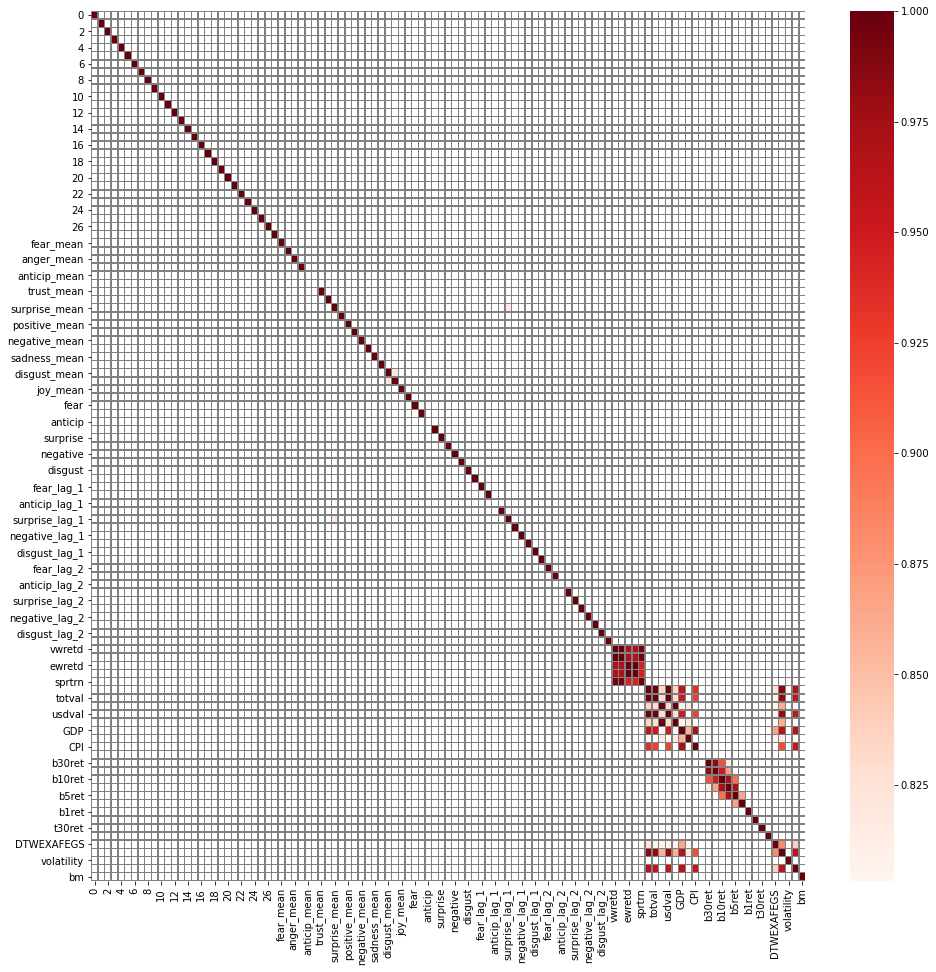

In [14]:
X = df.drop(columns=['Date','return'])

#Correlation matrix 
import seaborn as sns
fig = plt.figure(figsize=(16,16))
correlation = X.corr()
sns.heatmap(correlation, mask=correlation<0.8,linewidth=0.5,linecolor='Grey',cmap='Reds')

In [15]:
correlated_features = list()

for i in range(len(correlation.columns)):
    for j in range(i):
        if abs(correlation.iloc[i, j]) > 0.8:
            colname = correlation.columns[i]
            correlated_features.append(colname)

<AxesSubplot:>

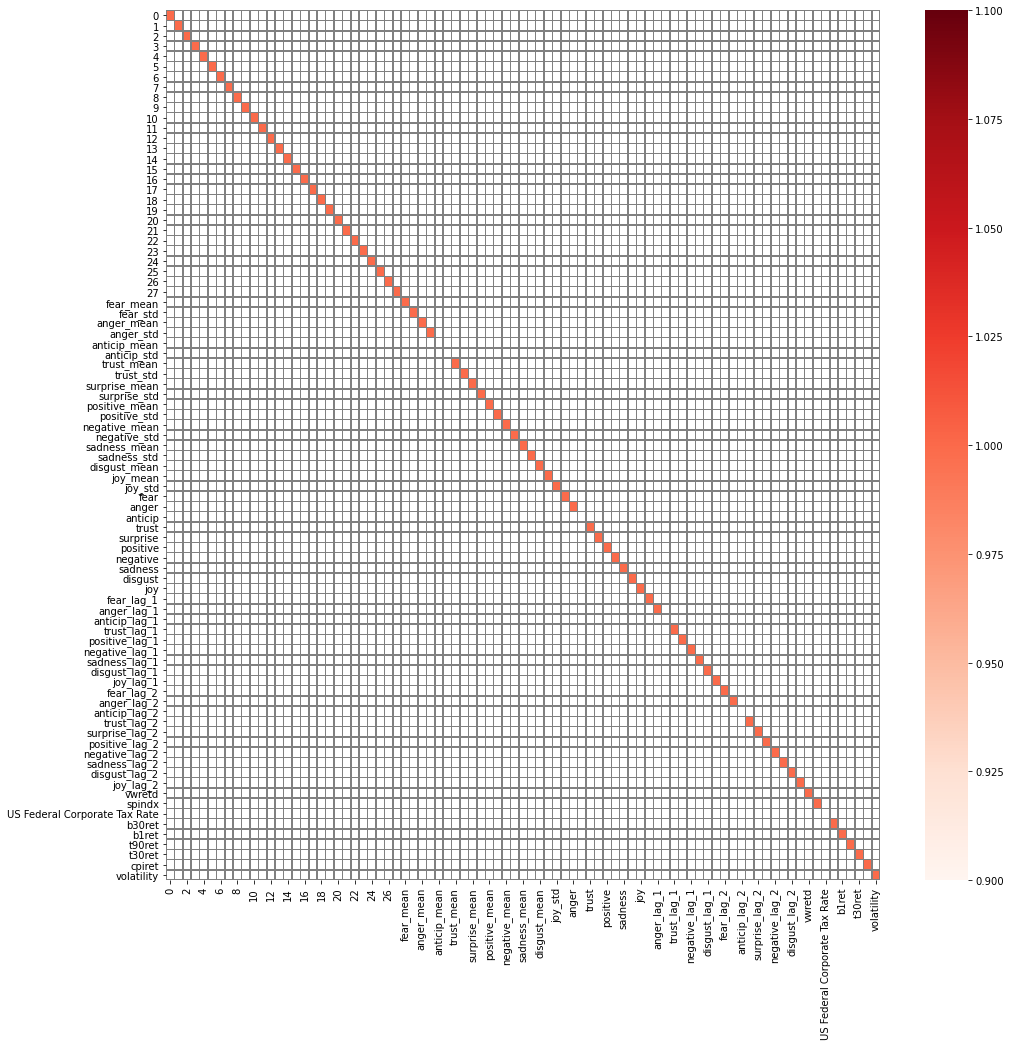

In [17]:
# columns to drop
X.drop(columns=correlated_features,inplace=True)

# check again
fig = plt.figure(figsize=(16,16))
correlation = X.corr()
sns.heatmap(correlation, mask=correlation<0.8,linewidth=0.5,linecolor='Grey',cmap='Reds')

## Model

In [18]:
X_train, X_test, Y_train, Y_test, X, Y = train_test_data(df)

scaler = StandardScaler()
pipe = Pipeline([('scaler',scaler),('reg',XGBRegressor(random_state = 42))])

xgb_parameters = [{
    'reg__objective':['reg:squarederror'],
    'reg__learning_rate':stats.uniform(0.01,0.5),
    'reg__max_depth':[3, 5],
    'reg__min_child_weight':[1,3],
    'reg__subsample':stats.uniform(0.3,0.6),
    'reg__colsample_bytree':stats.uniform(0.5,0.4),
    'reg__n_estimators': stats.randint(10,1000)
}]

grid_pipe = RandomizedSearchCV(pipe, xgb_parameters, scoring = "neg_mean_squared_error", n_iter = 5, cv = 5, 
                               verbose = 2, return_train_score = True)

grid_pipe.fit(X_train,Y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END reg__colsample_bytree=0.7535736309171467, reg__learning_rate=0.39101703824255185, reg__max_depth=5, reg__min_child_weight=3, reg__n_estimators=458, reg__objective=reg:squarederror, reg__subsample=0.3200462757452949; total time=   0.6s
[CV] END reg__colsample_bytree=0.7535736309171467, reg__learning_rate=0.39101703824255185, reg__max_depth=5, reg__min_child_weight=3, reg__n_estimators=458, reg__objective=reg:squarederror, reg__subsample=0.3200462757452949; total time=   0.4s
[CV] END reg__colsample_bytree=0.7535736309171467, reg__learning_rate=0.39101703824255185, reg__max_depth=5, reg__min_child_weight=3, reg__n_estimators=458, reg__objective=reg:squarederror, reg__subsample=0.3200462757452949; total time=   0.5s
[CV] END reg__colsample_bytree=0.7535736309171467, reg__learning_rate=0.39101703824255185, reg__max_depth=5, reg__min_child_weight=3, reg__n_estimators=458, reg__objective=reg:squarederror, reg__subsample=0.3

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('reg',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           importance_type='gain',
                                                           interaction_constraints=None,
                                                           learning_rate=None,
                                                         

In [19]:
print(grid_pipe.best_score_)
print(mean_squared_error(Y_test,grid_pipe.predict(X_test)))
grid_pipe.best_params_

-0.0001305056572897607
0.00012421799399737031


{'reg__colsample_bytree': 0.69615412796724,
 'reg__learning_rate': 0.04964330541960687,
 'reg__max_depth': 5,
 'reg__min_child_weight': 3,
 'reg__n_estimators': 758,
 'reg__objective': 'reg:squarederror',
 'reg__subsample': 0.4474805653434575}

In [20]:
X_train.columns.values

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 'fear_mean', 'fear_std',
       'anger_mean', 'anger_std', 'anticip_mean', 'anticip_std',
       'trust_mean', 'trust_std', 'surprise_mean', 'surprise_std',
       'positive_mean', 'positive_std', 'negative_mean', 'negative_std',
       'sadness_mean', 'sadness_std', 'disgust_mean', 'disgust_std',
       'joy_mean', 'joy_std', 'fear', 'anger', 'anticip', 'trust',
       'surprise', 'positive', 'negative', 'sadness', 'disgust', 'joy',
       'fear_lag_1', 'anger_lag_1', 'anticip_lag_1', 'trust_lag_1',
       'surprise_lag_1', 'positive_lag_1', 'negative_lag_1',
       'sadness_lag_1', 'disgust_lag_1', 'joy_lag_1', 'fear_lag_2',
       'anger_lag_2', 'anticip_lag_2', 'trust_lag_2', 'surprise_lag_2',
       'positive_lag_2', 'negative_lag_2', 'sadness_lag_2',
       'disgust_lag_2', 'joy_lag_2', 'vwretd', 'vwretx', 'ewretd',
       'ewretx', 'sprtrn', 'spindx', 'totval', 'to

In [22]:
topic = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27]
sent = ['fear_mean', 'fear_std',
       'anger_mean', 'anger_std', 'anticip_mean', 'anticip_std',
       'trust_mean', 'trust_std', 'surprise_mean', 'surprise_std',
       'positive_mean', 'positive_std', 'negative_mean', 'negative_std',
       'sadness_mean', 'sadness_std', 'disgust_mean', 'disgust_std',
       'joy_mean', 'joy_std', 'fear', 'anger', 'anticip', 'trust',
       'surprise', 'positive', 'negative', 'sadness', 'disgust', 'joy',
       'fear_lag_1', 'anger_lag_1', 'anticip_lag_1', 'trust_lag_1',
       'surprise_lag_1', 'positive_lag_1', 'negative_lag_1',
       'sadness_lag_1', 'disgust_lag_1', 'joy_lag_1', 'fear_lag_2',
       'anger_lag_2', 'anticip_lag_2', 'trust_lag_2', 'surprise_lag_2',
       'positive_lag_2', 'negative_lag_2', 'sadness_lag_2',
       'disgust_lag_2', 'joy_lag_2']
ecnm = ['vwretd', 'vwretx', 'ewretd',
       'ewretx', 'sprtrn', 'spindx', 'totval', 'totcnt', 'usdval',
       'usdcnt', 'GDP', 'GDP Growth (%)', 'CPI',
       'US Federal Corporate Tax Rate', 'b30ret', 'b20ret', 'b10ret',
       'b7ret', 'b5ret', 'b2ret', 'b1ret', 't90ret', 't30ret', 'cpiret',
       'DTWEXAFEGS', 'momtm', 'volatility', 'size_log', 'bm']

features = get_features(grid_pipe)
features

,features,imp
25,25,0.034768
7,7,0.030260
0,0,0.029634
26,26,0.026691
22,22,0.023708
57,joy,0.011250
72,surprise_lag_2,0.011210
69,anger_lag_2,0.010137
46,joy_mean,0.009670
49,anger,0.009595


                          features       imp
7                                7  0.042830
25                              25  0.037345
86                          usdval  0.026416
84                          totval  0.026246
106                             bm  0.025996
..                             ...       ...
33                     anticip_std  0.000000
70                   anticip_lag_2  0.000000
91   US Federal Corporate Tax Rate  0.000000
90                             CPI  0.000000
32                    anticip_mean  0.000000

[107 rows x 2 columns]


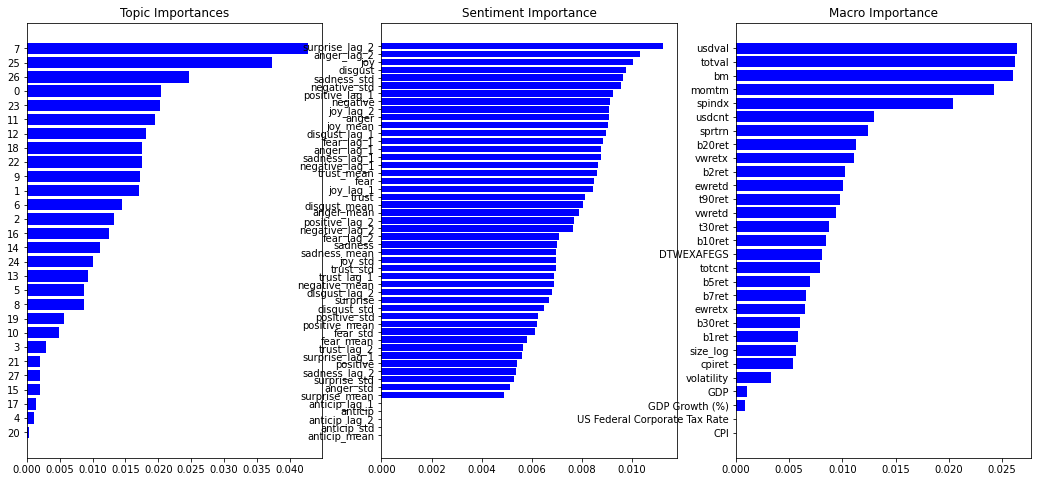

In [24]:
model = sub_feature_importance(grid_pipe.best_estimator_.named_steps["reg"])

In [25]:
# save the model to disk
import joblib
filename = 'dis_2010_2015_model.sav'
joblib.dump(grid_pipe, filename)
 
# some time later...
 
# # load the model from disk
# loaded_model = joblib.load(filename)

['dis_2010_2015_model.sav']

# 2015/06 - 2017/06

## Data Preprocess

In [26]:
START_PERIOD = '2015/06/01'
END_PERIOD = '2017/06/01'

# 8 files
dis_twitter = pd.read_csv("DIS_2010-12-31_2021-06-30_twitter_Sentimental_NoDuplicates.csv")
dis_cnbc = pd.read_csv("/Users/emma/Desktop/MS Data Challenge/Model/dis_news.csv")
dis_return_data = pd.read_csv("/Users/emma/Desktop/MS Data Challenge/Model/dis_return.csv")
eco = pd.read_csv("/Users/emma/Desktop/MS Data Challenge/WRDS/CRSP_Stock_Market_Indexes.csv")
treasury = pd.read_csv("/Users/emma/Desktop/MS Data Challenge/WRDS/US_Treasury&Inflation_(monthly).csv")
macro = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/WRDS/US_Macro.csv')
ex_rate = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/WRDS/Exchange Rates.csv')
company = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/WRDS/dis_updated.csv')

dis_return_data['return'] = (dis_return_data['Close'] - dis_return_data['Open'])/dis_return_data['Open']
stock_date_open = dis_return_data['Date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date()).tolist()
dis_return_data = dis_return_data[['Date', 'return']]
dis_return_data['Date'] = pd.to_datetime(dis_return_data['Date'])

In [27]:
dis_twitter['date'] = pd.to_datetime(dis_twitter['date'], errors='coerce')
dis_twitter = dis_twitter[(dis_twitter['date'] >= datetime.strptime(START_PERIOD, '%Y/%m/%d'))
                        & (dis_twitter['date'] <= datetime.strptime(END_PERIOD, '%Y/%m/%d'))]
dis_twitter = add_market_open_date(dis_twitter, 'date')
dis_twitter['closest_market_date'] = dis_twitter['closest_market_date'].apply(lambda x: x.date())
dis_df = dis_twitter.groupby("closest_market_date")['fear', 'anger', 'anticip', 'trust', 'surprise',
       'positive', 'negative', 'sadness', 'disgust', 'joy'].mean().reset_index()

dis_df_shift_lag_1 = dis_df.drop('closest_market_date', axis=1).shift(periods=1, axis=0)
dis_df_shift_lag_1.columns = [col+'_lag_1' for col in dis_df_shift_lag_1.columns]
dis_df_shift_lag_2 = dis_df.drop('closest_market_date', axis=1).shift(periods=2, axis=0)
dis_df_shift_lag_2.columns = [col+'_lag_2' for col in dis_df_shift_lag_2.columns]
temp = dis_df.rolling(window=3, min_periods=1).agg(['mean', 'std'])
temp.columns = list(map('_'.join, temp.columns.values))
dis_df = pd.concat([dis_df[['closest_market_date']], 
                    temp,
                    dis_df.drop('closest_market_date', axis=1), 
                    dis_df_shift_lag_1, 
                    dis_df_shift_lag_2], axis=1)
dis_df

,closest_market_date,fear_mean,fear_std,anger_mean,anger_std,anticip_mean,anticip_std,trust_mean,trust_std,surprise_mean,...,fear_lag_2,anger_lag_2,anticip_lag_2,trust_lag_2,surprise_lag_2,positive_lag_2,negative_lag_2,sadness_lag_2,disgust_lag_2,joy_lag_2
0,2015-06-01,0.032800,NaN,0.013158,NaN,0.0,NaN,0.053482,NaN,0.068423,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-06-02,0.035174,0.003357,0.011399,0.002488,0.0,0.0,0.059542,0.008571,0.070195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-06-03,0.037441,0.004588,0.012042,0.002082,0.0,0.0,0.053868,0.011546,0.071521,...,0.032800,0.013158,0.0,0.053482,0.068423,0.167345,0.064282,0.012269,0.004919,0.036406
3,2015-06-04,0.033470,0.011119,0.011724,0.001891,0.0,0.0,0.051367,0.012449,0.073379,...,0.037548,0.009640,0.0,0.065603,0.071967,0.201623,0.078224,0.012920,0.005743,0.035303
4,2015-06-05,0.029794,0.010918,0.013463,0.001331,0.0,0.0,0.045281,0.002487,0.072535,...,0.041975,0.013329,0.0,0.042520,0.074174,0.182231,0.076407,0.023137,0.009011,0.050350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,2017-05-24,0.020177,0.001812,0.014693,0.003738,0.0,0.0,0.059509,0.007047,0.032283,...,0.018319,0.010421,0.0,0.067636,0.042340,0.203984,0.077660,0.013736,0.004550,0.056078
500,2017-05-25,0.019533,0.002850,0.015440,0.002465,0.0,0.0,0.050637,0.008336,0.030370,...,0.021939,0.017366,0.0,0.055088,0.025129,0.209252,0.067983,0.018544,0.010348,0.043566
501,2017-05-26,0.017072,0.002919,0.013355,0.002660,0.0,0.0,0.051885,0.009530,0.034286,...,0.020273,0.016292,0.0,0.055803,0.029380,0.301508,0.054142,0.010116,0.002029,0.059742
502,2017-05-30,0.019766,0.007495,0.012397,0.001177,0.0,0.0,0.052669,0.010093,0.034567,...,0.016386,0.012663,0.0,0.041021,0.036600,0.242314,0.068769,0.016465,0.009004,0.057277


In [28]:
dis_cnbc['date'] = pd.to_datetime(dis_cnbc['date']).apply(lambda x: x.date())
dis_cnbc = add_market_open_date(dis_cnbc, 'date')
dis_cnbc_agg = dis_cnbc.groupby(['closest_market_date', 'topic'])['compound_sent'].sum().reset_index()
dis_cnbc_agg.columns = ['Date', 'topic', 'compound_sent_cnbc']

temp_df = dis_cnbc_agg.pivot(index='Date', 
                             columns='topic', 
                             values='compound_sent_cnbc').reset_index().rename_axis(None, axis=1)
temp_df['Date'] = pd.to_datetime(temp_df['Date'])
dis_return_data['Date'] = pd.to_datetime(dis_return_data['Date'])
dis_return_data = dis_return_data.merge(temp_df, how='left', on='Date')
dis_return_data = dis_return_data.fillna(0)
dis_df['closest_market_date'] = pd.to_datetime(dis_df['closest_market_date'])
dis_return_data['Date'] = pd.to_datetime(dis_return_data['Date'])
ret_df = dis_return_data.merge(dis_df, how='left', left_on='Date', right_on='closest_market_date')
# ret_df = ret_df.dropna()
ret_df = ret_df.drop("closest_market_date", axis=1)

ret_df

,Date,return,0,1,2,3,4,5,6,7,...,fear_lag_2,anger_lag_2,anticip_lag_2,trust_lag_2,surprise_lag_2,positive_lag_2,negative_lag_2,sadness_lag_2,disgust_lag_2,joy_lag_2
0,2010-01-04,-0.013231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,-0.002495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-06,-0.002508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-07,0.001889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-08,0.006949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2910,2021-07-27,0.007013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2911,2021-07-28,-0.003283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2912,2021-07-29,-0.008120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2913,2021-07-30,-0.008506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
eco = pd.read_csv("/Users/emma/Desktop/MS Data Challenge/WRDS/CRSP_Stock_Market_Indexes.csv")
treasury = pd.read_csv("/Users/emma/Desktop/MS Data Challenge/WRDS/US_Treasury&Inflation_(monthly).csv")
macro = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/WRDS/US_Macro.csv')
ex_rate = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/WRDS/Exchange Rates.csv')
company = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/WRDS/dis_updated.csv')

eco.DATE = eco.DATE.astype(str)
eco.DATE = eco.DATE.apply(lambda x: datetime.strptime(x, '%Y%m%d'))
eco_shift = eco.drop('DATE', axis=1).shift(periods=-1, axis=0)
eco = pd.concat([eco['DATE'], eco_shift], axis=1)

df = ret_df.merge(eco, how='left', left_on='Date',right_on='DATE')
df.Date.nunique()

treasury.caldt = treasury.caldt.astype(str)
treasury.caldt = treasury.caldt.apply(lambda x: datetime.strptime(x, '%Y%m%d'))
treasury['month_year'] = pd.to_datetime(treasury['caldt']).dt.to_period('M')

df['Year'] = df['Date'].dt.to_period('Y')
df['Year'] = df['Year'].apply(lambda x: float(str(x)))
df = df.merge(macro, how='left', on='Year')

df['month_year'] = pd.to_datetime(df['Date']).dt.to_period('M')
df = df.merge(treasury, how='left', on='month_year')

df.drop(columns=['DATE','month_year','caldt','Year'],inplace=True)
df.dropna(inplace=True)

df['GDP'] = df['GDP'].apply(lambda x: float(x[1:-1].replace(',',''))*1000000000)

df['GDP Growth (%)'] = df['GDP Growth (%)'].apply(lambda x: float(x[:-1].replace('%',''))/100)

df['US Federal Corporate Tax Rate'] = df['US Federal Corporate Tax Rate'].apply(lambda x: float(x[:-1].replace('%',''))/100)
#df=df.fillna(0)

ex_rate['Date'] = ex_rate.DATE.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

df = df.merge(ex_rate, how='left', on='Date')

def ex_rate(x):
    try: return float(x)
    except: return np.nan
df['DTWEXAFEGS'] = df['DTWEXAFEGS'].apply(lambda x: ex_rate(x))
df['DTWEXAFEGS'] = df['DTWEXAFEGS'].fillna(method='ffill')
df

,Date,return,0,1,2,3,4,5,6,7,...,b10ret,b7ret,b5ret,b2ret,b1ret,t90ret,t30ret,cpiret,DATE,DTWEXAFEGS
0,2015-06-03,0.003792,0.0,0.0,0.0000,0.0,0.000,0.0,0.0000,0.0,...,-0.018369,-0.011399,-0.005355,0.000394,-0.000054,0.000029,0.000004,0.003503,2015-06-03,106.5494
1,2015-06-04,-0.005858,0.0,0.0,0.0000,0.0,0.000,0.0,0.0000,0.0,...,-0.018369,-0.011399,-0.005355,0.000394,-0.000054,0.000029,0.000004,0.003503,2015-06-04,106.7982
2,2015-06-05,0.000000,0.0,0.0,-0.4404,0.0,0.000,0.0,0.0000,0.0,...,-0.018369,-0.011399,-0.005355,0.000394,-0.000054,0.000029,0.000004,0.003503,2015-06-05,107.7061
3,2015-06-08,-0.006725,0.0,0.0,0.0000,0.0,0.000,0.0,0.0000,0.0,...,-0.018369,-0.011399,-0.005355,0.000394,-0.000054,0.000029,0.000004,0.003503,2015-06-08,106.9777
4,2015-06-09,-0.007590,0.0,0.0,0.0000,0.0,0.000,0.0,0.0000,0.0,...,-0.018369,-0.011399,-0.005355,0.000394,-0.000054,0.000029,0.000004,0.003503,2015-06-09,106.2695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,2017-05-24,0.005226,0.0,0.0,0.0000,0.0,0.000,0.0,0.9062,0.0,...,0.007856,0.007299,0.004701,0.001096,0.000730,0.000588,0.000614,0.000855,2017-05-24,110.4481
498,2017-05-25,-0.007953,0.0,0.0,0.0000,0.0,0.000,0.0,0.0000,0.0,...,0.007856,0.007299,0.004701,0.001096,0.000730,0.000588,0.000614,0.000855,2017-05-25,110.1960
499,2017-05-26,0.006499,0.0,0.0,0.0000,0.0,0.000,0.0,0.0000,0.0,...,0.007856,0.007299,0.004701,0.001096,0.000730,0.000588,0.000614,0.000855,2017-05-26,110.5016
500,2017-05-30,-0.001383,0.0,0.0,0.0000,0.0,0.000,0.0,0.5106,0.0,...,0.007856,0.007299,0.004701,0.001096,0.000730,0.000588,0.000614,0.000855,2017-05-30,110.3192


In [31]:
company['date'] = company['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
company.drop(columns=['Unnamed: 0'],inplace=True)
df = df.merge(company,how='left',left_on='Date',right_on='date')

df.drop(columns=['date','DATE'],inplace=True)

In [32]:
df.to_csv('dis_15-17.csv')

<AxesSubplot:>

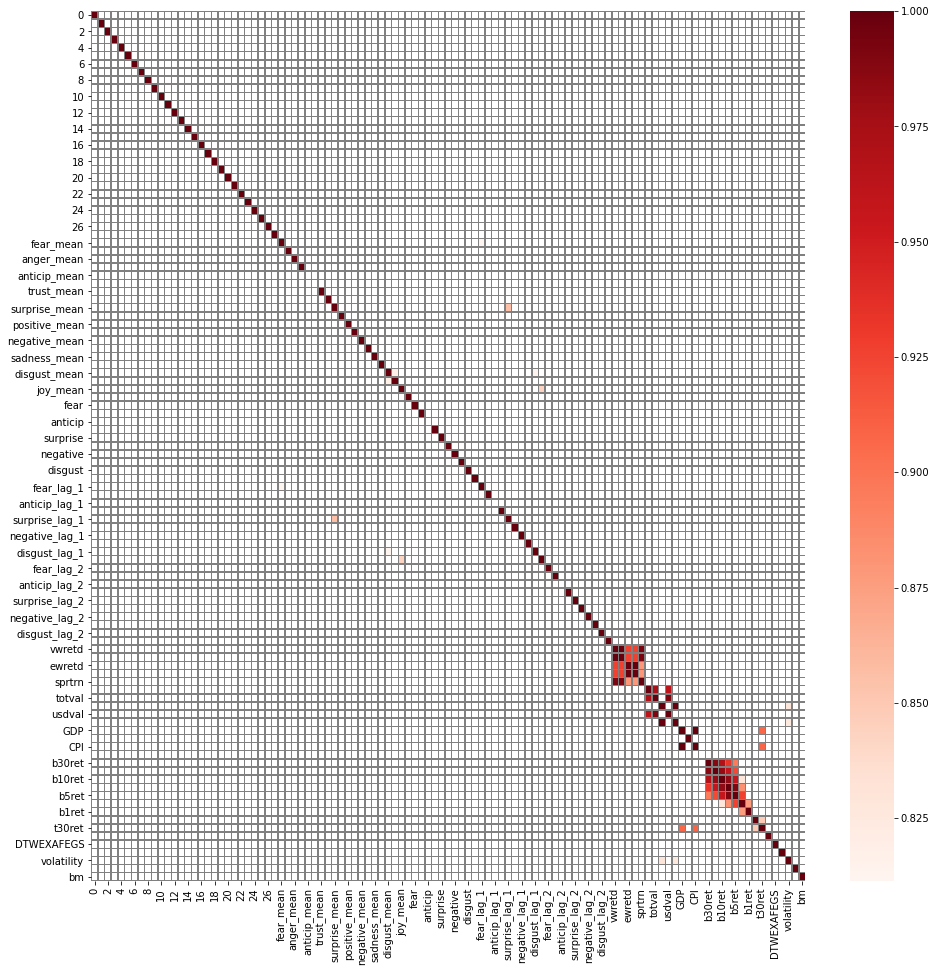

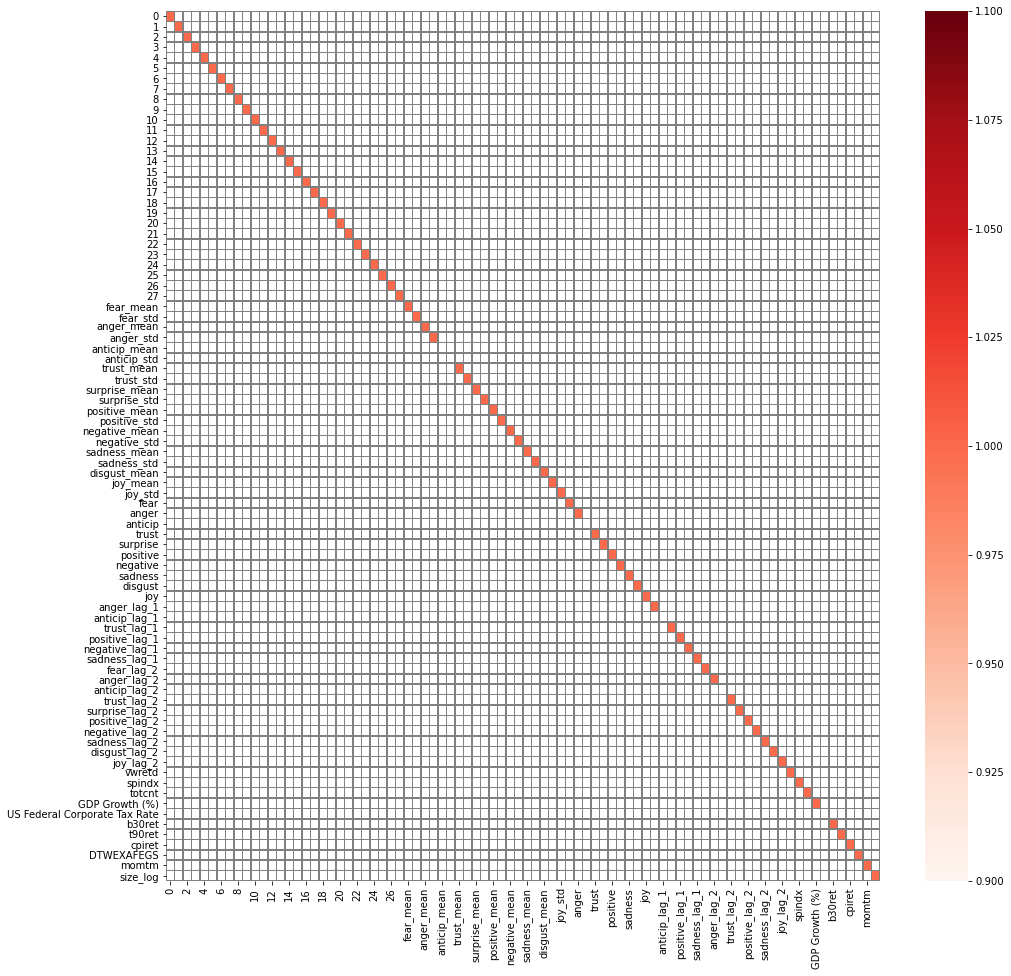

In [33]:
X = df.drop(columns=['Date','return'])

#Correlation matrix 
import seaborn as sns
fig = plt.figure(figsize=(16,16))
correlation = X.corr()
sns.heatmap(correlation, mask=correlation<0.8,linewidth=0.5,linecolor='Grey',cmap='Reds')

correlated_features = list()

for i in range(len(correlation.columns)):
    for j in range(i):
        if abs(correlation.iloc[i, j]) > 0.8:
            colname = correlation.columns[i]
            correlated_features.append(colname)
            
# columns to drop
X.drop(columns=correlated_features,inplace=True)

# check again
fig = plt.figure(figsize=(16,16))
correlation = X.corr()
sns.heatmap(correlation, mask=correlation<0.8,linewidth=0.5,linecolor='Grey',cmap='Reds')

In [34]:
X_train, X_test, Y_train, Y_test, X, Y = train_test_data(df)

scaler = StandardScaler()
pipe = Pipeline([('scaler',scaler),('reg',XGBRegressor(random_state = 42))])

xgb_parameters = [{
    'reg__objective':['reg:squarederror'],
    'reg__learning_rate':stats.uniform(0.01,0.5),
    'reg__max_depth':[3, 5],
    'reg__min_child_weight':[1,3],
    'reg__subsample':stats.uniform(0.3,0.6),
    'reg__colsample_bytree':stats.uniform(0.5,0.4),
    'reg__n_estimators': stats.randint(10,1000)
}]

grid_pipe = RandomizedSearchCV(pipe, xgb_parameters, scoring = "neg_mean_squared_error", n_iter = 5, cv = 5, 
                               verbose = 2, return_train_score = True)

grid_pipe.fit(X_train,Y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END reg__colsample_bytree=0.6641692792797402, reg__learning_rate=0.06791987439560086, reg__max_depth=3, reg__min_child_weight=3, reg__n_estimators=80, reg__objective=reg:squarederror, reg__subsample=0.5124361098002183; total time=   0.1s
[CV] END reg__colsample_bytree=0.6641692792797402, reg__learning_rate=0.06791987439560086, reg__max_depth=3, reg__min_child_weight=3, reg__n_estimators=80, reg__objective=reg:squarederror, reg__subsample=0.5124361098002183; total time=   0.1s
[CV] END reg__colsample_bytree=0.6641692792797402, reg__learning_rate=0.06791987439560086, reg__max_depth=3, reg__min_child_weight=3, reg__n_estimators=80, reg__objective=reg:squarederror, reg__subsample=0.5124361098002183; total time=   0.1s
[CV] END reg__colsample_bytree=0.6641692792797402, reg__learning_rate=0.06791987439560086, reg__max_depth=3, reg__min_child_weight=3, reg__n_estimators=80, reg__objective=reg:squarederror, reg__subsample=0.51243

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('reg',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           importance_type='gain',
                                                           interaction_constraints=None,
                                                           learning_rate=None,
                                                         

In [35]:
print(grid_pipe.best_score_)
print(mean_squared_error(Y_test,grid_pipe.predict(X_test)))
grid_pipe.best_params_

-8.610077925862584e-05
8.547514733541415e-05


{'reg__colsample_bytree': 0.6641692792797402,
 'reg__learning_rate': 0.06791987439560086,
 'reg__max_depth': 3,
 'reg__min_child_weight': 3,
 'reg__n_estimators': 80,
 'reg__objective': 'reg:squarederror',
 'reg__subsample': 0.5124361098002183}

In [36]:
X_train.columns.values

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 'fear_mean', 'fear_std',
       'anger_mean', 'anger_std', 'anticip_mean', 'anticip_std',
       'trust_mean', 'trust_std', 'surprise_mean', 'surprise_std',
       'positive_mean', 'positive_std', 'negative_mean', 'negative_std',
       'sadness_mean', 'sadness_std', 'disgust_mean', 'disgust_std',
       'joy_mean', 'joy_std', 'fear', 'anger', 'anticip', 'trust',
       'surprise', 'positive', 'negative', 'sadness', 'disgust', 'joy',
       'fear_lag_1', 'anger_lag_1', 'anticip_lag_1', 'trust_lag_1',
       'surprise_lag_1', 'positive_lag_1', 'negative_lag_1',
       'sadness_lag_1', 'disgust_lag_1', 'joy_lag_1', 'fear_lag_2',
       'anger_lag_2', 'anticip_lag_2', 'trust_lag_2', 'surprise_lag_2',
       'positive_lag_2', 'negative_lag_2', 'sadness_lag_2',
       'disgust_lag_2', 'joy_lag_2', 'vwretd', 'vwretx', 'ewretd',
       'ewretx', 'sprtrn', 'spindx', 'totval', 'to

In [37]:
topic = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27]
sent = ['fear_mean', 'fear_std',
       'anger_mean', 'anger_std', 'anticip_mean', 'anticip_std',
       'trust_mean', 'trust_std', 'surprise_mean', 'surprise_std',
       'positive_mean', 'positive_std', 'negative_mean', 'negative_std',
       'sadness_mean', 'sadness_std', 'disgust_mean', 'disgust_std',
       'joy_mean', 'joy_std', 'fear', 'anger', 'anticip', 'trust',
       'surprise', 'positive', 'negative', 'sadness', 'disgust', 'joy',
       'fear_lag_1', 'anger_lag_1', 'anticip_lag_1', 'trust_lag_1',
       'surprise_lag_1', 'positive_lag_1', 'negative_lag_1',
       'sadness_lag_1', 'disgust_lag_1', 'joy_lag_1', 'fear_lag_2',
       'anger_lag_2', 'anticip_lag_2', 'trust_lag_2', 'surprise_lag_2',
       'positive_lag_2', 'negative_lag_2', 'sadness_lag_2',
       'disgust_lag_2', 'joy_lag_2']
ecnm = ['vwretd', 'vwretx', 'ewretd',
       'ewretx', 'sprtrn', 'spindx', 'totval', 'totcnt', 'usdval',
       'usdcnt', 'GDP', 'GDP Growth (%)', 'CPI',
       'US Federal Corporate Tax Rate', 'b30ret', 'b20ret', 'b10ret',
       'b7ret', 'b5ret', 'b2ret', 'b1ret', 't90ret', 't30ret', 'cpiret',
       'DTWEXAFEGS', 'momtm', 'volatility', 'size_log', 'bm']

features = get_features(grid_pipe)
features

,features,imp
23,23,0.022504
18,18,0.015954
1,1,0.015440
21,21,0.015356
16,16,0.015293
46,joy_mean,0.026192
74,negative_lag_2,0.021349
73,positive_lag_2,0.020780
52,surprise,0.019907
56,disgust,0.019532


          features       imp
46        joy_mean  0.026192
23              23  0.022504
74  negative_lag_2  0.021349
73  positive_lag_2  0.020780
96           b5ret  0.020018
..             ...       ...
81          ewretx  0.000000
22              22  0.000000
19              19  0.000000
17              17  0.000000
0                0  0.000000

[107 rows x 2 columns]


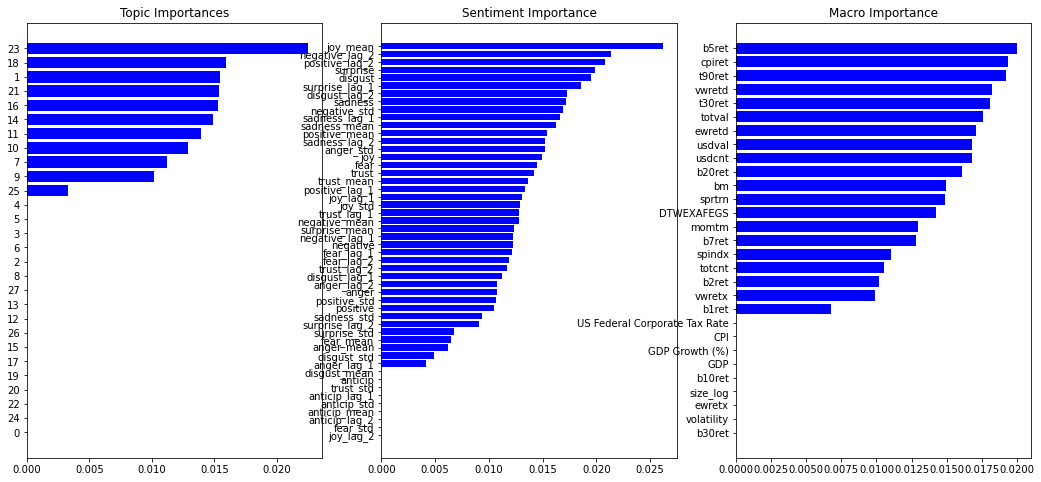

In [38]:
model = sub_feature_importance(grid_pipe.best_estimator_.named_steps["reg"])

In [39]:
# save the model to disk
import joblib
filename = 'dis_2015_2017_model.sav'
joblib.dump(grid_pipe, filename)
 
# some time later...
 
# # load the model from disk
# loaded_model = joblib.load(filename)

['dis_2015_2017_model.sav']

In [40]:
START_PERIOD = '2017/06/01'
END_PERIOD = '2019/07/01'

# 8 files
dis_twitter = pd.read_csv("DIS_2010-12-31_2021-06-30_twitter_Sentimental_NoDuplicates.csv")
dis_cnbc = pd.read_csv("/Users/emma/Desktop/MS Data Challenge/Model/dis_news.csv")
dis_return_data = pd.read_csv("/Users/emma/Desktop/MS Data Challenge/Model/dis_return.csv")
eco = pd.read_csv("/Users/emma/Desktop/MS Data Challenge/WRDS/CRSP_Stock_Market_Indexes.csv")
treasury = pd.read_csv("/Users/emma/Desktop/MS Data Challenge/WRDS/US_Treasury&Inflation_(monthly).csv")
macro = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/WRDS/US_Macro.csv')
ex_rate = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/WRDS/Exchange Rates.csv')
company = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/WRDS/dis_updated.csv')

dis_return_data['return'] = (dis_return_data['Close'] - dis_return_data['Open'])/dis_return_data['Open']
stock_date_open = dis_return_data['Date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date()).tolist()
dis_return_data = dis_return_data[['Date', 'return']]
dis_return_data['Date'] = pd.to_datetime(dis_return_data['Date'])

In [41]:
dis_twitter['date'] = pd.to_datetime(dis_twitter['date'], errors='coerce')
dis_twitter = dis_twitter[(dis_twitter['date'] >= datetime.strptime(START_PERIOD, '%Y/%m/%d'))
                        & (dis_twitter['date'] <= datetime.strptime(END_PERIOD, '%Y/%m/%d'))]
dis_twitter = add_market_open_date(dis_twitter, 'date')
dis_twitter['closest_market_date'] = dis_twitter['closest_market_date'].apply(lambda x: x.date())
dis_df = dis_twitter.groupby("closest_market_date")['fear', 'anger', 'anticip', 'trust', 'surprise',
       'positive', 'negative', 'sadness', 'disgust', 'joy'].mean().reset_index()

dis_df_shift_lag_1 = dis_df.drop('closest_market_date', axis=1).shift(periods=1, axis=0)
dis_df_shift_lag_1.columns = [col+'_lag_1' for col in dis_df_shift_lag_1.columns]
dis_df_shift_lag_2 = dis_df.drop('closest_market_date', axis=1).shift(periods=2, axis=0)
dis_df_shift_lag_2.columns = [col+'_lag_2' for col in dis_df_shift_lag_2.columns]
temp = dis_df.rolling(window=3, min_periods=1).agg(['mean', 'std'])
temp.columns = list(map('_'.join, temp.columns.values))
dis_df = pd.concat([dis_df[['closest_market_date']], 
                    temp,
                    dis_df.drop('closest_market_date', axis=1), 
                    dis_df_shift_lag_1, 
                    dis_df_shift_lag_2], axis=1)
dis_df

,closest_market_date,fear_mean,fear_std,anger_mean,anger_std,anticip_mean,anticip_std,trust_mean,trust_std,surprise_mean,...,fear_lag_2,anger_lag_2,anticip_lag_2,trust_lag_2,surprise_lag_2,positive_lag_2,negative_lag_2,sadness_lag_2,disgust_lag_2,joy_lag_2
0,2017-06-01,0.021701,NaN,0.009377,NaN,0.0,NaN,0.075148,NaN,0.030170,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-06-02,0.021383,0.000450,0.010157,0.001103,0.0,0.0,0.069539,0.007932,0.030093,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-06-05,0.021208,0.000439,0.010227,0.000789,0.0,0.0,0.070559,0.005880,0.030162,...,0.021701,0.009377,0.0,0.075148,0.030170,0.242020,0.064514,0.015121,0.004744,0.039075
3,2017-06-06,0.021444,0.000841,0.010355,0.000587,0.0,0.0,0.070133,0.005410,0.031982,...,0.021065,0.010937,0.0,0.063930,0.030015,0.210481,0.051417,0.011670,0.003236,0.050738
4,2017-06-07,0.021161,0.001127,0.010113,0.000313,0.0,0.0,0.072986,0.000770,0.027283,...,0.020860,0.010366,0.0,0.072598,0.030302,0.207337,0.065414,0.015203,0.004759,0.054909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,2019-06-25,0.024775,0.007833,0.008795,0.001835,0.0,0.0,0.059524,0.000312,0.026105,...,0.031408,0.010712,0.0,0.059299,0.029932,0.219150,0.065046,0.019407,0.008420,0.054471
520,2019-06-26,0.018599,0.007272,0.009669,0.003269,0.0,0.0,0.056100,0.006131,0.020091,...,0.026783,0.008620,0.0,0.059393,0.021370,0.223738,0.065326,0.015655,0.006730,0.060755
521,2019-06-27,0.023716,0.016033,0.008970,0.003788,0.0,0.0,0.054900,0.005482,0.021560,...,0.016134,0.007054,0.0,0.059880,0.027011,0.220860,0.066735,0.012944,0.006308,0.050943
522,2019-06-28,0.027344,0.014630,0.012343,0.005394,0.0,0.0,0.055803,0.006781,0.019419,...,0.012880,0.013333,0.0,0.049026,0.011890,0.277572,0.039855,0.007800,0.008254,0.062957


In [42]:
dis_cnbc['date'] = pd.to_datetime(dis_cnbc['date']).apply(lambda x: x.date())
dis_cnbc = add_market_open_date(dis_cnbc, 'date')
dis_cnbc_agg = dis_cnbc.groupby(['closest_market_date', 'topic'])['compound_sent'].sum().reset_index()
dis_cnbc_agg.columns = ['Date', 'topic', 'compound_sent_cnbc']

temp_df = dis_cnbc_agg.pivot(index='Date', 
                             columns='topic', 
                             values='compound_sent_cnbc').reset_index().rename_axis(None, axis=1)
temp_df['Date'] = pd.to_datetime(temp_df['Date'])
dis_return_data['Date'] = pd.to_datetime(dis_return_data['Date'])
dis_return_data = dis_return_data.merge(temp_df, how='left', on='Date')
dis_return_data = dis_return_data.fillna(0)
dis_df['closest_market_date'] = pd.to_datetime(dis_df['closest_market_date'])
dis_return_data['Date'] = pd.to_datetime(dis_return_data['Date'])
ret_df = dis_return_data.merge(dis_df, how='left', left_on='Date', right_on='closest_market_date')
# ret_df = ret_df.dropna()
ret_df = ret_df.drop("closest_market_date", axis=1)

ret_df

,Date,return,0,1,2,3,4,5,6,7,...,fear_lag_2,anger_lag_2,anticip_lag_2,trust_lag_2,surprise_lag_2,positive_lag_2,negative_lag_2,sadness_lag_2,disgust_lag_2,joy_lag_2
0,2010-01-04,-0.013231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,-0.002495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-06,-0.002508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-07,0.001889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-08,0.006949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2910,2021-07-27,0.007013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2911,2021-07-28,-0.003283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2912,2021-07-29,-0.008120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2913,2021-07-30,-0.008506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
eco = pd.read_csv("/Users/emma/Desktop/MS Data Challenge/WRDS/CRSP_Stock_Market_Indexes.csv")
treasury = pd.read_csv("/Users/emma/Desktop/MS Data Challenge/WRDS/US_Treasury&Inflation_(monthly).csv")
macro = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/WRDS/US_Macro.csv')
ex_rate = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/WRDS/Exchange Rates.csv')
company = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/WRDS/dis_updated.csv')

eco.DATE = eco.DATE.astype(str)
eco.DATE = eco.DATE.apply(lambda x: datetime.strptime(x, '%Y%m%d'))
eco_shift = eco.drop('DATE', axis=1).shift(periods=-1, axis=0)
eco = pd.concat([eco['DATE'], eco_shift], axis=1)

df = ret_df.merge(eco, how='left', left_on='Date',right_on='DATE')
df.Date.nunique()

2915

In [44]:
treasury.caldt = treasury.caldt.astype(str)
treasury.caldt = treasury.caldt.apply(lambda x: datetime.strptime(x, '%Y%m%d'))
treasury['month_year'] = pd.to_datetime(treasury['caldt']).dt.to_period('M')

df['Year'] = df['Date'].dt.to_period('Y')
df['Year'] = df['Year'].apply(lambda x: float(str(x)))
df = df.merge(macro, how='left', on='Year')

df['month_year'] = pd.to_datetime(df['Date']).dt.to_period('M')
df = df.merge(treasury, how='left', on='month_year')

df.drop(columns=['DATE','month_year','caldt','Year'],inplace=True)
df.dropna(inplace=True)

df['GDP'] = df['GDP'].apply(lambda x: float(x[1:-1].replace(',',''))*1000000000)

df['GDP Growth (%)'] = df['GDP Growth (%)'].apply(lambda x: float(x[:-1].replace('%',''))/100)

df['US Federal Corporate Tax Rate'] = df['US Federal Corporate Tax Rate'].apply(lambda x: float(x[:-1].replace('%',''))/100)
#df=df.fillna(0)

ex_rate['Date'] = ex_rate.DATE.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

df = df.merge(ex_rate, how='left', on='Date')

def ex_rate(x):
    try: return float(x)
    except: return np.nan
df['DTWEXAFEGS'] = df['DTWEXAFEGS'].apply(lambda x: ex_rate(x))
df['DTWEXAFEGS'] = df['DTWEXAFEGS'].fillna(method='ffill')
df

,Date,return,0,1,2,3,4,5,6,7,...,b10ret,b7ret,b5ret,b2ret,b1ret,t90ret,t30ret,cpiret,DATE,DTWEXAFEGS
0,2017-06-05,-0.004858,0.0,0.5719,-0.296,-0.1531,0.0,-0.3425,0.0000,-0.4215,...,-0.001307,-0.005711,-0.003845,-0.000752,0.000320,0.000873,0.000617,0.000907,2017-06-05,109.9674
1,2017-06-06,-0.006311,0.0,0.0000,0.000,0.0000,0.0,0.0000,0.5106,-0.0900,...,-0.001307,-0.005711,-0.003845,-0.000752,0.000320,0.000873,0.000617,0.000907,2017-06-06,109.6643
2,2017-06-07,0.001229,0.0,0.0000,0.000,0.0000,0.0,0.0000,0.0000,0.0000,...,-0.001307,-0.005711,-0.003845,-0.000752,0.000320,0.000873,0.000617,0.000907,2017-06-07,109.9157
3,2017-06-08,-0.015106,0.0,0.0000,0.000,0.0000,0.0,0.0000,0.0000,0.0000,...,-0.001307,-0.005711,-0.003845,-0.000752,0.000320,0.000873,0.000617,0.000907,2017-06-08,110.0341
4,2017-06-09,0.012850,0.0,0.0000,0.000,0.6369,0.0,0.0000,0.0000,0.0000,...,-0.001307,-0.005711,-0.003845,-0.000752,0.000320,0.000873,0.000617,0.000907,2017-06-09,110.2737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,2019-06-25,0.006618,0.0,0.0000,0.000,0.0000,0.0,0.0000,0.0000,0.0000,...,0.012073,0.010693,0.008867,0.004399,0.003795,0.002163,0.001853,0.000199,2019-06-25,108.8726
518,2019-06-26,0.000285,0.0,0.0000,0.000,0.0000,0.0,0.0000,0.0000,0.0000,...,0.012073,0.010693,0.008867,0.004399,0.003795,0.002163,0.001853,0.000199,2019-06-26,108.8651
519,2019-06-27,-0.012057,0.0,0.0000,0.000,0.0000,0.0,0.0000,0.0000,0.4939,...,0.012073,0.010693,0.008867,0.004399,0.003795,0.002163,0.001853,0.000199,2019-06-27,108.9836
520,2019-06-28,0.001650,0.0,0.0000,0.000,0.0000,0.0,0.0000,0.0000,0.0000,...,0.012073,0.010693,0.008867,0.004399,0.003795,0.002163,0.001853,0.000199,2019-06-28,108.9012


In [45]:
company['date'] = company['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
company.drop(columns=['Unnamed: 0'],inplace=True)
df = df.merge(company,how='left',left_on='Date',right_on='date')

df.drop(columns=['date','DATE'],inplace=True)

In [47]:
df.to_csv('dis_17-19.csv')

<AxesSubplot:>

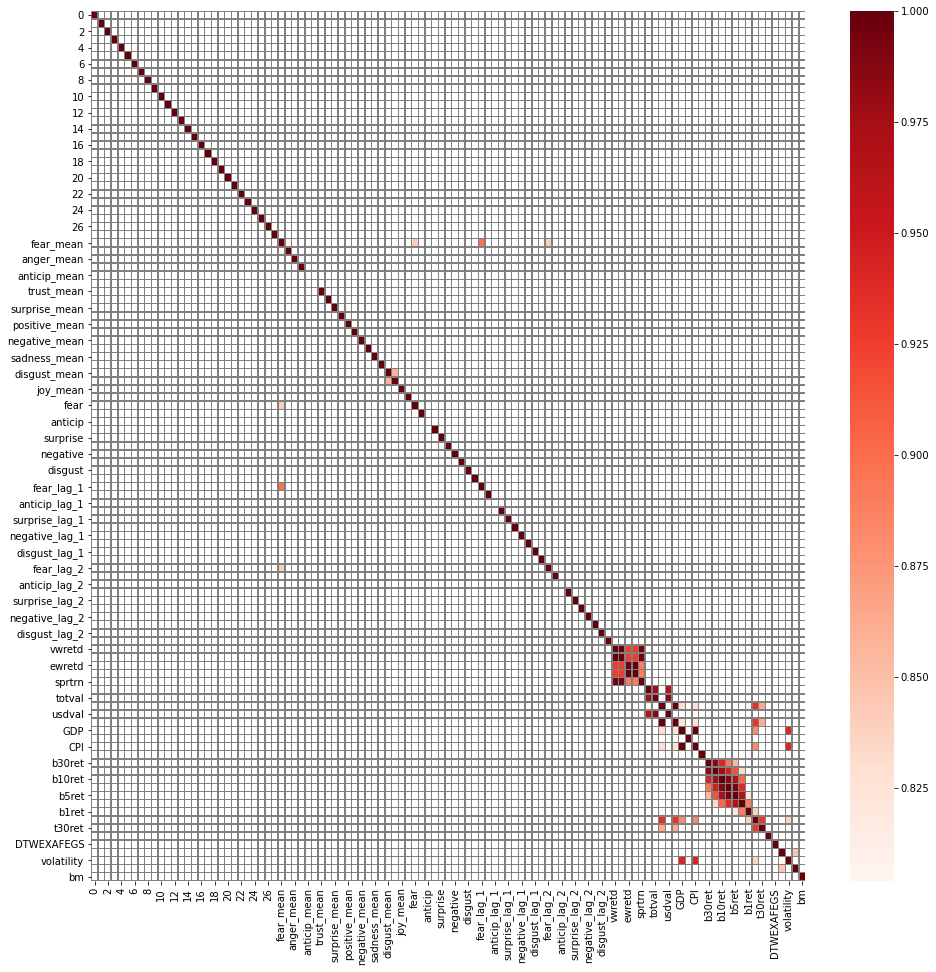

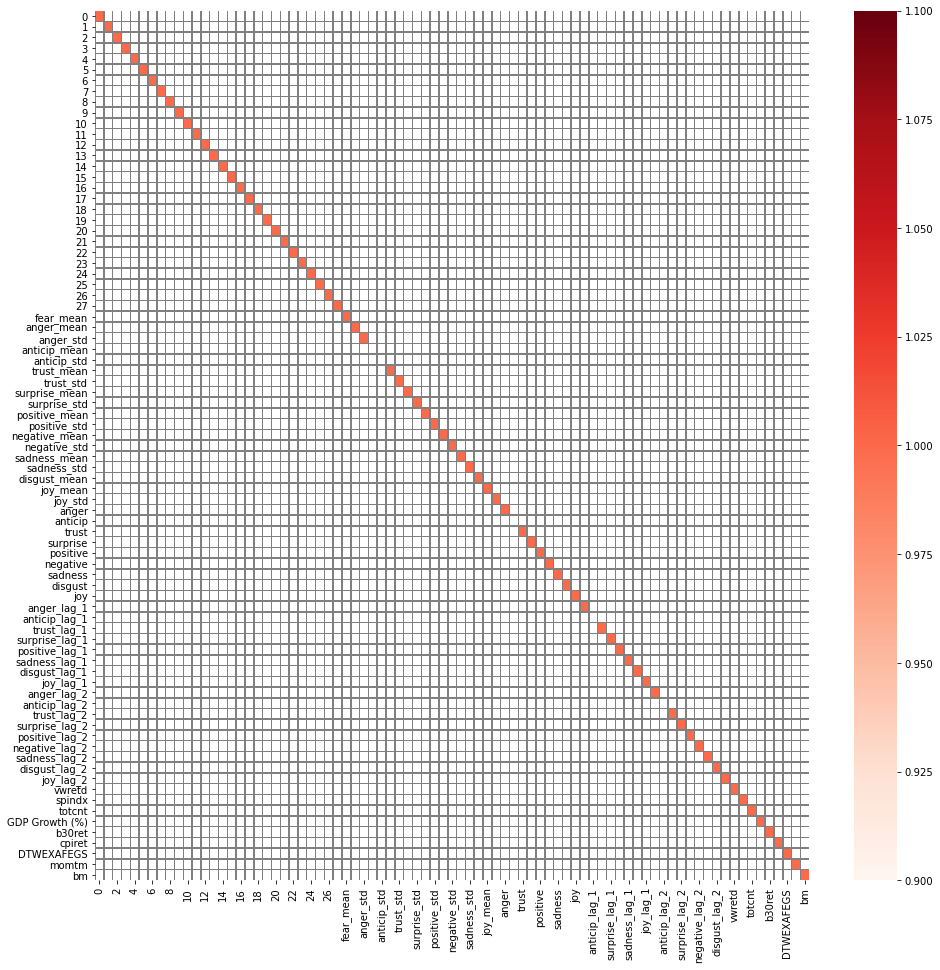

In [48]:
X = df.drop(columns=['Date','return'])

#Correlation matrix 
import seaborn as sns
fig = plt.figure(figsize=(16,16))
correlation = X.corr()
sns.heatmap(correlation, mask=correlation<0.8,linewidth=0.5,linecolor='Grey',cmap='Reds')

correlated_features = list()

for i in range(len(correlation.columns)):
    for j in range(i):
        if abs(correlation.iloc[i, j]) > 0.8:
            colname = correlation.columns[i]
            correlated_features.append(colname)
            
# columns to drop
X.drop(columns=correlated_features,inplace=True)

# check again
fig = plt.figure(figsize=(16,16))
correlation = X.corr()
sns.heatmap(correlation, mask=correlation<0.8,linewidth=0.5,linecolor='Grey',cmap='Reds')

In [49]:
X_train, X_test, Y_train, Y_test, X, Y = train_test_data(df)

scaler = StandardScaler()
pipe = Pipeline([('scaler',scaler),('reg',XGBRegressor(random_state = 42))])

xgb_parameters = [{
    'reg__objective':['reg:squarederror'],
    'reg__learning_rate':stats.uniform(0.01,0.5),
    'reg__max_depth':[3, 5],
    'reg__min_child_weight':[1,3],
    'reg__subsample':stats.uniform(0.3,0.6),
    'reg__colsample_bytree':stats.uniform(0.5,0.4),
    'reg__n_estimators': stats.randint(10,1000)
}]

grid_pipe = RandomizedSearchCV(pipe, xgb_parameters, scoring = "neg_mean_squared_error", n_iter = 5, cv = 5, 
                               verbose = 2, return_train_score = True)

grid_pipe.fit(X_train,Y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END reg__colsample_bytree=0.7858972829833568, reg__learning_rate=0.4882126289007863, reg__max_depth=5, reg__min_child_weight=3, reg__n_estimators=653, reg__objective=reg:squarederror, reg__subsample=0.8049996296034958; total time=   0.4s
[CV] END reg__colsample_bytree=0.7858972829833568, reg__learning_rate=0.4882126289007863, reg__max_depth=5, reg__min_child_weight=3, reg__n_estimators=653, reg__objective=reg:squarederror, reg__subsample=0.8049996296034958; total time=   0.4s
[CV] END reg__colsample_bytree=0.7858972829833568, reg__learning_rate=0.4882126289007863, reg__max_depth=5, reg__min_child_weight=3, reg__n_estimators=653, reg__objective=reg:squarederror, reg__subsample=0.8049996296034958; total time=   0.4s
[CV] END reg__colsample_bytree=0.7858972829833568, reg__learning_rate=0.4882126289007863, reg__max_depth=5, reg__min_child_weight=3, reg__n_estimators=653, reg__objective=reg:squarederror, reg__subsample=0.80499

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('reg',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           importance_type='gain',
                                                           interaction_constraints=None,
                                                           learning_rate=None,
                                                         

In [50]:
print(grid_pipe.best_score_)
print(mean_squared_error(Y_test,grid_pipe.predict(X_test)))
grid_pipe.best_params_

-0.00014776248832718494
0.0001770134417000922


{'reg__colsample_bytree': 0.7945523339648246,
 'reg__learning_rate': 0.3397560945280728,
 'reg__max_depth': 3,
 'reg__min_child_weight': 3,
 'reg__n_estimators': 685,
 'reg__objective': 'reg:squarederror',
 'reg__subsample': 0.5962294330414184}

In [51]:
features = get_features(grid_pipe)
features

,features,imp
2,2,0.051802
17,17,0.049675
7,7,0.029143
18,18,0.028849
23,23,0.028064
36,surprise_mean,0.020277
43,sadness_std,0.020237
72,surprise_lag_2,0.017157
42,sadness_mean,0.016091
61,trust_lag_1,0.015773


       features       imp
88          GDP  0.069526
2             2  0.051802
17           17  0.049675
106          bm  0.038117
7             7  0.029143
..          ...       ...
12           12  0.000000
11           11  0.000000
104  volatility  0.000000
105    size_log  0.000000
20           20  0.000000

[107 rows x 2 columns]


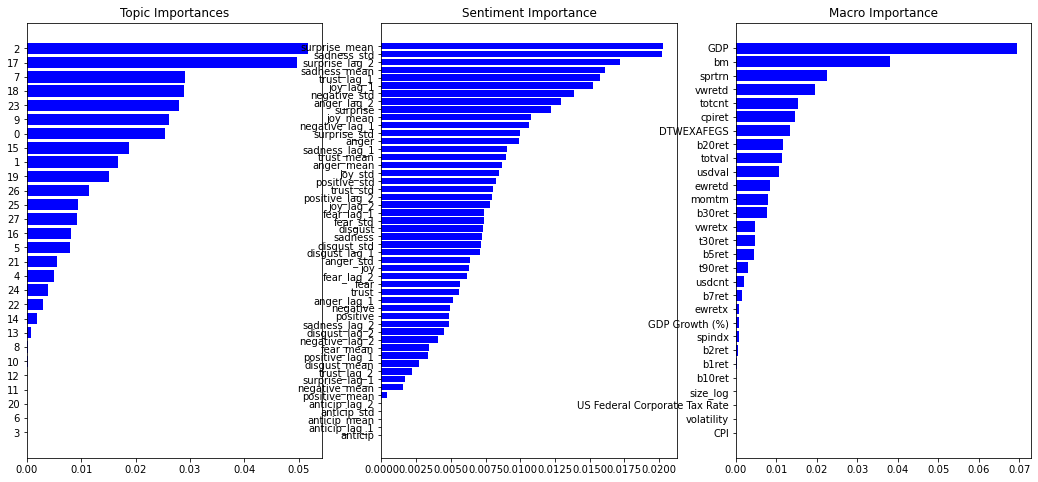

In [52]:
model = sub_feature_importance(grid_pipe.best_estimator_.named_steps["reg"])

In [53]:
# save the model to disk
import joblib
filename = 'dis_2017_2019_model.sav'
joblib.dump(grid_pipe, filename)
 
# some time later...
 
# # load the model from disk
# loaded_model = joblib.load(filename)

['dis_2017_2019_model.sav']

In [54]:
START_PERIOD = '2019/06/01'
END_PERIOD = '2021/07/01'

# 8 files
dis_twitter = pd.read_csv("DIS_2010-12-31_2021-06-30_twitter_Sentimental_NoDuplicates.csv")
dis_cnbc = pd.read_csv("/Users/emma/Desktop/MS Data Challenge/Model/dis_news.csv")
dis_return_data = pd.read_csv("/Users/emma/Desktop/MS Data Challenge/Model/dis_return.csv")
eco = pd.read_csv("/Users/emma/Desktop/MS Data Challenge/WRDS/CRSP_Stock_Market_Indexes.csv")
treasury = pd.read_csv("/Users/emma/Desktop/MS Data Challenge/WRDS/US_Treasury&Inflation_(monthly).csv")
macro = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/WRDS/US_Macro.csv')
ex_rate = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/WRDS/Exchange Rates.csv')
company = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/WRDS/dis_updated.csv')

dis_return_data['return'] = (dis_return_data['Close'] - dis_return_data['Open'])/dis_return_data['Open']
stock_date_open = dis_return_data['Date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date()).tolist()
dis_return_data = dis_return_data[['Date', 'return']]
dis_return_data['Date'] = pd.to_datetime(dis_return_data['Date'])

In [55]:
dis_twitter['date'] = pd.to_datetime(dis_twitter['date'], errors='coerce')
dis_twitter = dis_twitter[(dis_twitter['date'] >= datetime.strptime(START_PERIOD, '%Y/%m/%d'))
                        & (dis_twitter['date'] <= datetime.strptime(END_PERIOD, '%Y/%m/%d'))]
dis_twitter = add_market_open_date(dis_twitter, 'date')
dis_twitter['closest_market_date'] = dis_twitter['closest_market_date'].apply(lambda x: x.date())
dis_df = dis_twitter.groupby("closest_market_date")['fear', 'anger', 'anticip', 'trust', 'surprise',
       'positive', 'negative', 'sadness', 'disgust', 'joy'].mean().reset_index()

dis_df_shift_lag_1 = dis_df.drop('closest_market_date', axis=1).shift(periods=1, axis=0)
dis_df_shift_lag_1.columns = [col+'_lag_1' for col in dis_df_shift_lag_1.columns]
dis_df_shift_lag_2 = dis_df.drop('closest_market_date', axis=1).shift(periods=2, axis=0)
dis_df_shift_lag_2.columns = [col+'_lag_2' for col in dis_df_shift_lag_2.columns]
temp = dis_df.rolling(window=3, min_periods=1).agg(['mean', 'std'])
temp.columns = list(map('_'.join, temp.columns.values))
dis_df = pd.concat([dis_df[['closest_market_date']], 
                    temp,
                    dis_df.drop('closest_market_date', axis=1), 
                    dis_df_shift_lag_1, 
                    dis_df_shift_lag_2], axis=1)
dis_df

,closest_market_date,fear_mean,fear_std,anger_mean,anger_std,anticip_mean,anticip_std,trust_mean,trust_std,surprise_mean,...,fear_lag_2,anger_lag_2,anticip_lag_2,trust_lag_2,surprise_lag_2,positive_lag_2,negative_lag_2,sadness_lag_2,disgust_lag_2,joy_lag_2
0,2019-06-03,0.030315,NaN,0.008303,NaN,0.0,NaN,0.045040,NaN,0.022405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-06-04,0.028909,0.001989,0.008764,0.000653,0.0,0.0,0.051060,0.008514,0.023974,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-06-05,0.039844,0.018992,0.006956,0.003166,0.0,0.0,0.051756,0.006140,0.024490,...,0.030315,0.008303,0.0,0.045040,0.022405,0.229650,0.092780,0.015933,0.004382,0.066604
3,2019-06-06,0.046791,0.017519,0.007886,0.004047,0.0,0.0,0.055256,0.001982,0.022611,...,0.027502,0.009226,0.0,0.057081,0.025543,0.255684,0.077266,0.019601,0.003435,0.053880
4,2019-06-07,0.046305,0.018323,0.008517,0.004485,0.0,0.0,0.050842,0.006183,0.022642,...,0.061714,0.003339,0.0,0.053147,0.025521,0.189642,0.077768,0.015476,0.008894,0.065868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,2021-06-24,0.040700,0.015666,0.013478,0.001972,0.0,0.0,0.059366,0.010750,0.032246,...,0.040302,0.011264,0.0,0.047444,0.031192,0.193443,0.060525,0.017378,0.005974,0.054225
520,2021-06-25,0.039821,0.015773,0.012508,0.003626,0.0,0.0,0.066034,0.003233,0.027997,...,0.056562,0.015044,0.0,0.068319,0.037990,0.214492,0.075248,0.012151,0.005950,0.063570
521,2021-06-28,0.032909,0.006707,0.011065,0.002902,0.0,0.0,0.061957,0.005690,0.021868,...,0.025238,0.014127,0.0,0.062335,0.027556,0.184511,0.074794,0.029016,0.008571,0.050571
522,2021-06-29,0.039054,0.004104,0.008550,0.002072,0.0,0.0,0.059785,0.006638,0.026683,...,0.037664,0.008355,0.0,0.067448,0.018446,0.206767,0.078238,0.016887,0.006123,0.040233


In [56]:
dis_cnbc['date'] = pd.to_datetime(dis_cnbc['date']).apply(lambda x: x.date())
dis_cnbc = add_market_open_date(dis_cnbc, 'date')
dis_cnbc_agg = dis_cnbc.groupby(['closest_market_date', 'topic'])['compound_sent'].sum().reset_index()
dis_cnbc_agg.columns = ['Date', 'topic', 'compound_sent_cnbc']

temp_df = dis_cnbc_agg.pivot(index='Date', 
                             columns='topic', 
                             values='compound_sent_cnbc').reset_index().rename_axis(None, axis=1)
temp_df['Date'] = pd.to_datetime(temp_df['Date'])
dis_return_data['Date'] = pd.to_datetime(dis_return_data['Date'])
dis_return_data = dis_return_data.merge(temp_df, how='left', on='Date')
dis_return_data = dis_return_data.fillna(0)
dis_df['closest_market_date'] = pd.to_datetime(dis_df['closest_market_date'])
dis_return_data['Date'] = pd.to_datetime(dis_return_data['Date'])
ret_df = dis_return_data.merge(dis_df, how='left', left_on='Date', right_on='closest_market_date')
# ret_df = ret_df.dropna()
ret_df = ret_df.drop("closest_market_date", axis=1)

ret_df.columns

Index([          'Date',         'return',                0,                1,
                      2,                3,                4,                5,
                      6,                7,                8,                9,
                     10,               11,               12,               13,
                     14,               15,               16,               17,
                     18,               19,               20,               21,
                     22,               23,               24,               25,
                     26,               27,      'fear_mean',       'fear_std',
           'anger_mean',      'anger_std',   'anticip_mean',    'anticip_std',
           'trust_mean',      'trust_std',  'surprise_mean',   'surprise_std',
        'positive_mean',   'positive_std',  'negative_mean',   'negative_std',
         'sadness_mean',    'sadness_std',   'disgust_mean',    'disgust_std',
             'joy_mean',        'joy_std',          

In [57]:
eco = pd.read_csv("/Users/emma/Desktop/MS Data Challenge/WRDS/CRSP_Stock_Market_Indexes.csv")
treasury = pd.read_csv("/Users/emma/Desktop/MS Data Challenge/WRDS/US_Treasury&Inflation_(monthly).csv")
macro = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/WRDS/US_Macro.csv')
ex_rate = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/WRDS/Exchange Rates.csv')
company = pd.read_csv('/Users/emma/Desktop/MS Data Challenge/WRDS/dis_updated.csv')

eco.DATE = eco.DATE.astype(str)
eco.DATE = eco.DATE.apply(lambda x: datetime.strptime(x, '%Y%m%d'))
eco_shift = eco.drop('DATE', axis=1).shift(periods=-1, axis=0)
eco = pd.concat([eco['DATE'], eco_shift], axis=1)

df = ret_df.merge(eco, how='left', left_on='Date',right_on='DATE')
df.Date.nunique()

treasury.caldt = treasury.caldt.astype(str)
treasury.caldt = treasury.caldt.apply(lambda x: datetime.strptime(x, '%Y%m%d'))
treasury['month_year'] = pd.to_datetime(treasury['caldt']).dt.to_period('M')

df['Year'] = df['Date'].dt.to_period('Y')
df['Year'] = df['Year'].apply(lambda x: float(str(x)))
df = df.merge(macro, how='left', on='Year')

df['month_year'] = pd.to_datetime(df['Date']).dt.to_period('M')
df = df.merge(treasury, how='left', on='month_year')

df.drop(columns=['DATE','month_year','caldt','Year'],inplace=True)
df.dropna(inplace=True)

df['GDP'] = df['GDP'].apply(lambda x: float(x[1:-1].replace(',',''))*1000000000)

df['GDP Growth (%)'] = df['GDP Growth (%)'].apply(lambda x: float(x[:-1].replace('%',''))/100)

df['US Federal Corporate Tax Rate'] = df['US Federal Corporate Tax Rate'].apply(lambda x: float(x[:-1].replace('%',''))/100)
#df=df.fillna(0)

ex_rate['Date'] = ex_rate.DATE.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

df = df.merge(ex_rate, how='left', on='Date')

def ex_rate(x):
    try: return float(x)
    except: return np.nan
df['DTWEXAFEGS'] = df['DTWEXAFEGS'].apply(lambda x: ex_rate(x))
df['DTWEXAFEGS'] = df['DTWEXAFEGS'].fillna(method='ffill')
df

,Date,return,0,1,2,3,4,5,6,7,...,b10ret,b7ret,b5ret,b2ret,b1ret,t90ret,t30ret,cpiret,DATE,DTWEXAFEGS
0,2019-06-05,0.003914,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,...,0.012073,0.010693,0.008867,0.004399,0.003795,0.002163,0.001853,0.000199,2019-06-05,110.2983
1,2019-06-06,0.005128,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,...,0.012073,0.010693,0.008867,0.004399,0.003795,0.002163,0.001853,0.000199,2019-06-06,109.9704
2,2019-06-07,0.003198,0.0,0.0,0.0000,0.0000,0.0,0.7096,0.0,0.0,...,0.012073,0.010693,0.008867,0.004399,0.003795,0.002163,0.001853,0.000199,2019-06-07,109.6271
3,2019-06-10,-0.013033,0.0,0.0,-0.5423,0.0000,0.0,0.0000,0.0,0.0,...,0.012073,0.010693,0.008867,0.004399,0.003795,0.002163,0.001853,0.000199,2019-06-10,109.7535
4,2019-06-11,-0.018243,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,...,0.012073,0.010693,0.008867,0.004399,0.003795,0.002163,0.001853,0.000199,2019-06-11,109.7858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,2020-12-22,0.002647,0.0,0.0,-0.3252,0.7717,0.0,0.0000,0.0,0.0,...,-0.004965,-0.001264,0.000855,0.000738,0.000297,0.000054,0.000060,0.000941,2020-12-22,103.6152
393,2020-12-23,0.003411,0.0,0.0,-0.8901,0.0000,0.0,0.0000,0.0,0.0,...,-0.004965,-0.001264,0.000855,0.000738,0.000297,0.000054,0.000060,0.000941,2020-12-23,103.1959
394,2020-12-24,-0.001494,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,...,-0.004965,-0.001264,0.000855,0.000738,0.000297,0.000054,0.000060,0.000941,2020-12-24,103.1959
395,2020-12-28,0.017696,0.0,0.0,0.0000,0.0000,0.0,0.0000,0.0,0.0,...,-0.004965,-0.001264,0.000855,0.000738,0.000297,0.000054,0.000060,0.000941,2020-12-28,103.3065


In [58]:
company['date'] = company['date'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
company.drop(columns=['Unnamed: 0'],inplace=True)
df = df.merge(company,how='left',left_on='Date',right_on='date')

df.drop(columns=['date','DATE'], inplace=True)

In [ ]:
df.to_csv('dis_19-21.csv')

<AxesSubplot:>

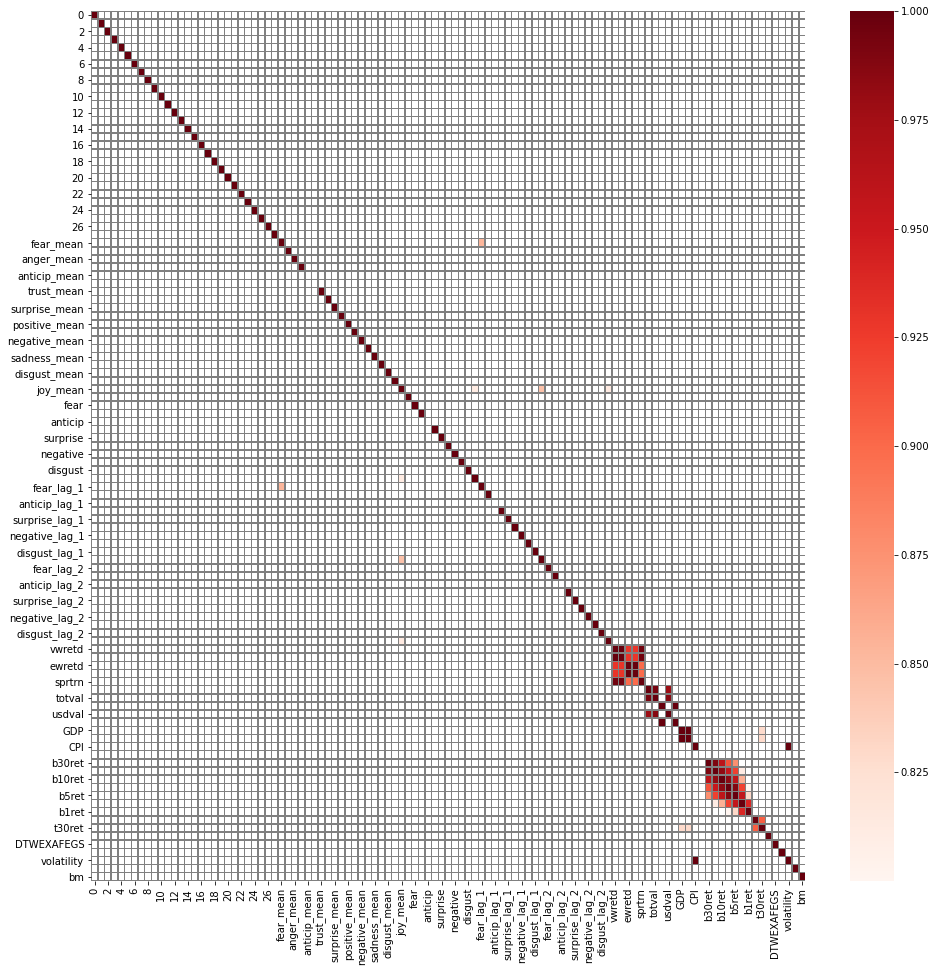

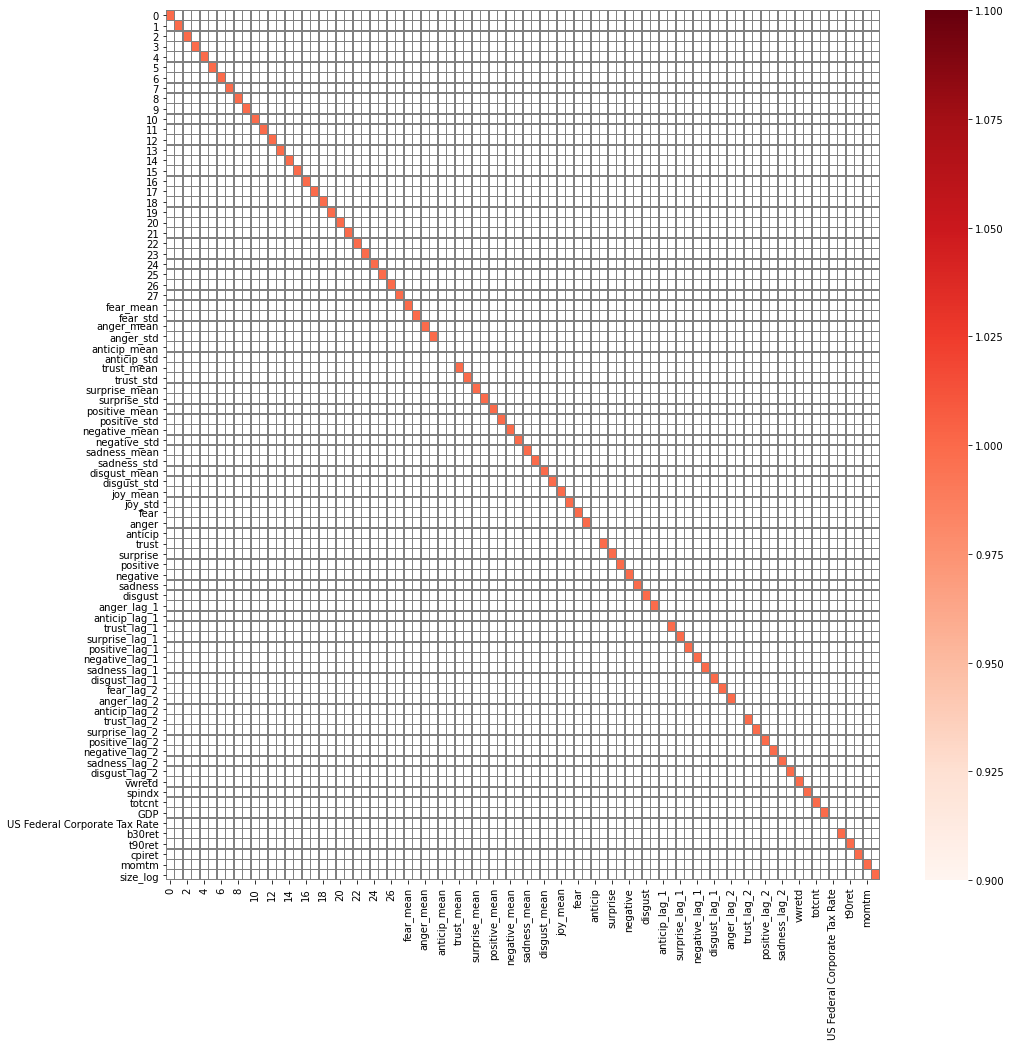

In [59]:
X = df.drop(columns=['Date','return'])

#Correlation matrix 
import seaborn as sns
fig = plt.figure(figsize=(16,16))
correlation = X.corr()
sns.heatmap(correlation, mask=correlation<0.8,linewidth=0.5,linecolor='Grey',cmap='Reds')

correlated_features = list()

for i in range(len(correlation.columns)):
    for j in range(i):
        if abs(correlation.iloc[i, j]) > 0.8:
            colname = correlation.columns[i]
            correlated_features.append(colname)
            
# columns to drop
X.drop(columns=correlated_features,inplace=True)

# check again
fig = plt.figure(figsize=(16,16))
correlation = X.corr()
sns.heatmap(correlation, mask=correlation<0.8,linewidth=0.5,linecolor='Grey',cmap='Reds')

In [60]:
X_train, X_test, Y_train, Y_test, X, Y = train_test_data(df)

scaler = StandardScaler()
pipe = Pipeline([('scaler',scaler),('reg',XGBRegressor(random_state = 42))])

xgb_parameters = [{
    'reg__objective':['reg:squarederror'],
    'reg__learning_rate':stats.uniform(0.01,0.5),
    'reg__max_depth':[3, 5],
    'reg__min_child_weight':[1,3],
    'reg__subsample':stats.uniform(0.3,0.6),
    'reg__colsample_bytree':stats.uniform(0.5,0.4),
    'reg__n_estimators': stats.randint(10,1000)
}]

grid_pipe = RandomizedSearchCV(pipe, xgb_parameters, scoring = "neg_mean_squared_error", n_iter = 5, cv = 5, 
                               verbose = 2, return_train_score = True)

grid_pipe.fit(X_train,Y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END reg__colsample_bytree=0.8680647197022286, reg__learning_rate=0.33935097870343556, reg__max_depth=3, reg__min_child_weight=3, reg__n_estimators=281, reg__objective=reg:squarederror, reg__subsample=0.3637733815432679; total time=   0.3s
[CV] END reg__colsample_bytree=0.8680647197022286, reg__learning_rate=0.33935097870343556, reg__max_depth=3, reg__min_child_weight=3, reg__n_estimators=281, reg__objective=reg:squarederror, reg__subsample=0.3637733815432679; total time=   0.2s
[CV] END reg__colsample_bytree=0.8680647197022286, reg__learning_rate=0.33935097870343556, reg__max_depth=3, reg__min_child_weight=3, reg__n_estimators=281, reg__objective=reg:squarederror, reg__subsample=0.3637733815432679; total time=   0.2s
[CV] END reg__colsample_bytree=0.8680647197022286, reg__learning_rate=0.33935097870343556, reg__max_depth=3, reg__min_child_weight=3, reg__n_estimators=281, reg__objective=reg:squarederror, reg__subsample=0.3

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('reg',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           importance_type='gain',
                                                           interaction_constraints=None,
                                                           learning_rate=None,
                                                         

In [61]:
print(grid_pipe.best_score_)
print(mean_squared_error(Y_test,grid_pipe.predict(X_test)))
grid_pipe.best_params_

-0.0005431718704578265
0.00027286645354001227


{'reg__colsample_bytree': 0.5180413694847621,
 'reg__learning_rate': 0.13470007503525744,
 'reg__max_depth': 3,
 'reg__min_child_weight': 3,
 'reg__n_estimators': 275,
 'reg__objective': 'reg:squarederror',
 'reg__subsample': 0.8609398842959366}

In [62]:
features = get_features(grid_pipe)
features

,features,imp
18,18,0.014654
16,16,0.010022
10,10,0.009419
23,23,0.009086
25,25,0.007782
72,surprise_lag_2,0.021238
34,trust_mean,0.019999
68,fear_lag_2,0.018310
67,joy_lag_1,0.017466
39,positive_std,0.017298


       features       imp
94       b10ret  0.080392
102  DTWEXAFEGS  0.046869
95        b7ret  0.044291
86       usdval  0.037912
83       spindx  0.031111
..          ...       ...
13           13  0.000000
9             9  0.000000
104  volatility  0.000000
3             3  0.000000
0             0  0.000000

[107 rows x 2 columns]


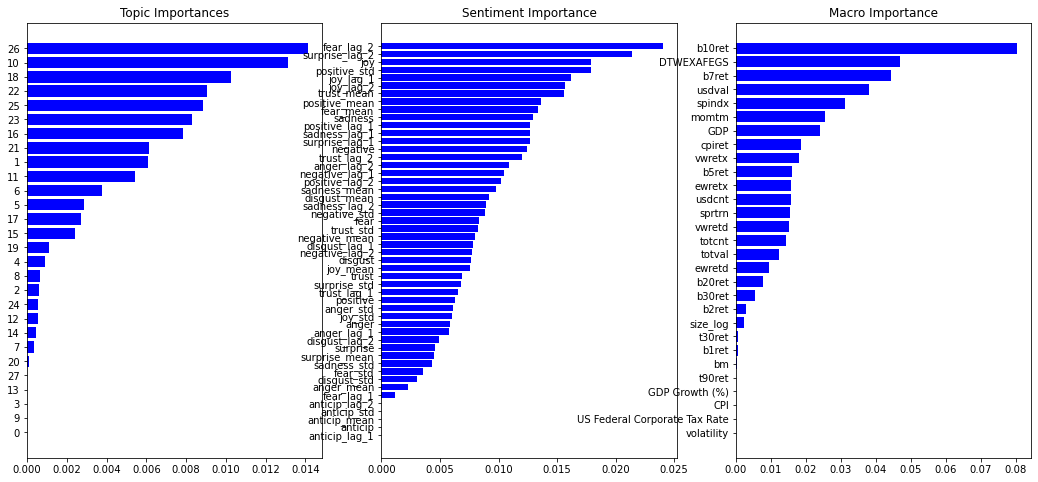

In [63]:
model = sub_feature_importance(grid_pipe.best_estimator_.named_steps["reg"])

In [64]:
# save the model to disk
import joblib
filename = 'dis_2019_2021_model.sav'
joblib.dump(grid_pipe, filename)
 
# some time later...
 
# # load the model from disk
# loaded_model = joblib.load(filename)

['dis_2019_2021_model.sav']